<a href="https://www.kaggle.com/code/atiaisaac/self-supervised-approach-to-image-classification?scriptVersionId=117316158" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import gc
from dataclasses import dataclass
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
from functools import partial
from tqdm import tqdm
try:
    import tensorflow_addons as tfa
except:
    !pip install tensorflow-addons
    import tensorflow_addons as tfa
from datetime import datetime
# from resnet import ResNet18

In [2]:
now = datetime.now()
date = now.strftime("%Y %m %d")

In [3]:
gc.collect()
tf.keras.backend.clear_session()

In [4]:
@dataclass
class C:
#     BASE_LR = 5e-3
    DECAY = 1e-4
    EPOCHS = 400
    GLOBAL_BATCH_SIZE = 64 # * strategy.num_replicas_in_sync
    INIT_LR = 5e-2
    HEIGHT = 120
    AUTO = tf.data.experimental.AUTOTUNE
    PROJECTION_DIM = 2048
    LATENT_DIM = 512
    SEED = 42
    BUFFER_SIZE = 1028
    M = 0.9
    SHAPE = [HEIGHT,HEIGHT]
    SCALE = (0.2,1.0) #same scale used in simsiam paper
    CLASSES = 120
#     H = {"loss": [], "proj_std": [], "pred_std": []}

In [5]:
train,val,test = tfds.load(
    "stanford_dogs",
    as_supervised = True,
    split = ["train[:80%]","train[80%:]","test"]
)

2023-01-25 21:32:17.824958: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


2023-01-25 21:33:40.906228: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 21:33:41.006789: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 21:33:41.007851: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 21:33:41.009845: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [6]:
print(tf.data.experimental.cardinality(train).numpy())
# print(tf.data.experimental.cardinality(query).numpy())
# print(tf.data.experimental.cardinality(index).numpy())
print(tf.data.experimental.cardinality(val).numpy())
print(tf.data.experimental.cardinality(test).numpy())

9600
2400
8580


In [7]:
x_train = train.map(lambda x, y: x)

### The SimSiam architecture requires that we make two augmented views of the same data. In the code cell below, we create functions for applying random augmentations

In [8]:
# https://github.com/sayakpaul/PAWS-TF/blob/main/utils/multicrop_loader.py#L86
# https://github.com/tensorflow/similarity/blob/master/tensorflow_similarity/augmenters/augmentation_utils/cropping.py
@tf.function
def _distorted_bounding_box_crop(
    image,bbox,min_object_covered=0.1,
    aspect_ratio_range=(0.75,1.33),
    area_range=(0.05,0.1),max_attempts=100
):
    shape = tf.shape(image)
    random_distorted_bbox = tf.image.sample_distorted_bounding_box(
        shape,
        bounding_boxes = bbox,
        min_object_covered = min_object_covered,
        aspect_ratio_range = aspect_ratio_range,
        area_range = area_range,
        max_attempts = max_attempts
    )
    offset,size,_ = random_distorted_bbox
    offset_y,offset_x,_ = tf.unstack(offset)
    target_y,target_x,_ = tf.unstack(size)
    image = tf.image.crop_to_bounding_box(
        image,offset_y,offset_x,target_y,target_x
    )
    return image

@tf.function    
def random_crop_resize(image,height,width,area_range=(0.08,1.0)):
    bbox = tf.constant([0.,0.,1.,1.],dtype=tf.float32,shape=[1,1,4])
    aspect_ratio = height / width
    image = _distorted_bounding_box_crop(
        image,bbox,aspect_ratio_range=(3.0/4.0 * aspect_ratio, 4.0/3.0 * aspect_ratio),
        area_range=area_range               
    )
    image = tf.image.resize(image,[height,width])
    return image

@tf.function
def gaussian_blur(image):
    image = tfa.image.gaussian_filter2d(image,sigma=(0.1,2.0))
                                       #filter_shape=(0.1*C.HEIGHT,0.1*C.HEIGHT))
    return image

def random_apply(func,image,prob):
    return tf.cond(
        tf.math.less(
            tf.random.uniform([],0,1,tf.float32),prob
        ),
        lambda:func(image),lambda:image
    )

@tf.function
def color_distortion(image,s=[0.4,0.4,0.4,0.1]):
    def _color_jitter(x):
        x = tf.image.random_brightness(x,max_delta = 0.8 * s[0])
        x = tf.image.random_contrast(x,
                                        lower = 1 - 0.8 * s[1],
                                        upper = 1 + 0.8 * s[1]
                                        )
        x = tf.image.random_saturation(x,
                                          lower = 1 - 0.8 * s[2],
                                          upper = 1 + 0.8 * s[2]
                                          )
        x = tf.image.random_hue(x,max_delta = 0.2 * s[3])
        x = tf.clip_by_value(x,0.,1.)
        return x

    def _color_drop(x):
        x = tf.image.rgb_to_grayscale(x)
        x = tf.tile(x,[1,1,3])
        return x
    
    image = random_apply(_color_jitter,image,0.8)
    image = random_apply(_color_drop,image,0.2)
    return image


def augment(image):
    image = random_crop_resize(image,C.HEIGHT,C.HEIGHT,area_range=C.SCALE) # prob = 1
    image = image/255.
    image = color_distortion(image)
    image = random_apply(gaussian_blur,image,0.5)
    image = tf.image.random_flip_left_right(image) # prob = 1 
    image = image * 255.
    return image 

## Random augmentations applied here to create two separate views

In [9]:
# for training
train_view_1 = (
    x_train.shuffle(C.BUFFER_SIZE,C.SEED)
    .map(lambda x: tf.image.resize(x,C.SHAPE),num_parallel_calls=C.AUTO)
    .map(augment,num_parallel_calls=C.AUTO)
    .batch(C.GLOBAL_BATCH_SIZE)
    .prefetch(C.AUTO)
)

train_view_2 = (
    x_train.shuffle(C.BUFFER_SIZE,C.SEED)
    .map(lambda x:tf.image.resize(x,C.SHAPE),num_parallel_calls=C.AUTO)
    .map(augment,num_parallel_calls=C.AUTO)
    .batch(C.GLOBAL_BATCH_SIZE)
    .prefetch(C.AUTO)
)

train_fused = tf.data.Dataset.zip((train_view_1,train_view_2))

print(train_fused)

<ZipDataset shapes: ((None, 120, 120, 3), (None, 120, 120, 3)), types: (tf.float32, tf.float32)>


# visualize the views

In [10]:
def visualize(sample):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(sample[n].numpy().astype('int'))
        plt.axis("off")
    plt.show()

2023-01-25 21:33:45.486207: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


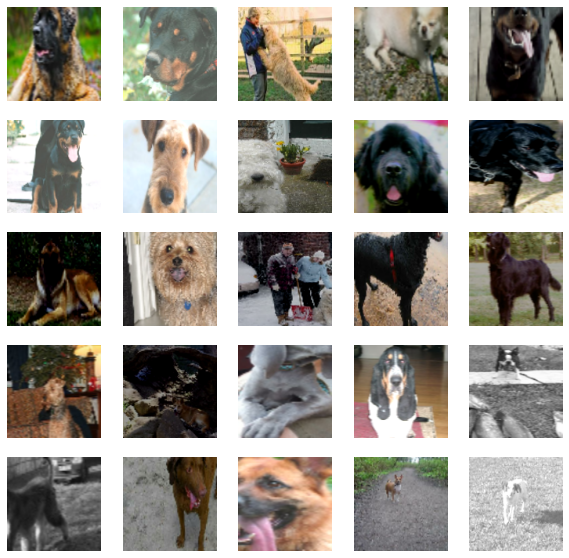

In [11]:
train_sample_one = next(iter(train_view_1))
visualize(train_sample_one)

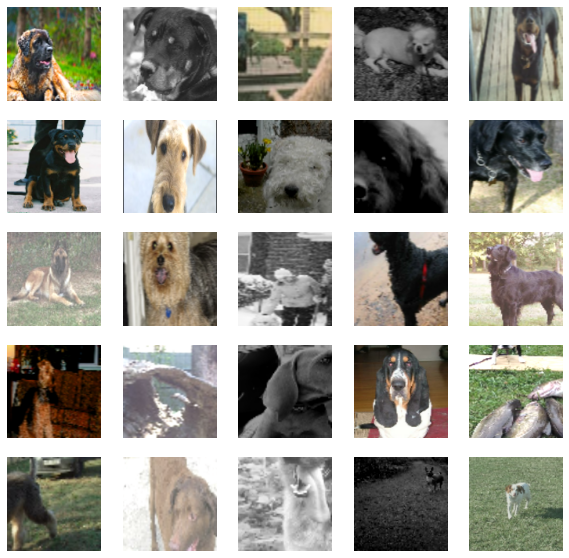

In [12]:
train_sample_two = next(iter(train_view_2))
visualize(train_sample_two)

This [example](https://keras.io/examples/vision/simsiam/) on the Keras website by Sayak Paul provides a tensorflow implementation of the Simsiam architecture from scratch - which is used in this notebook with some few modifications

In [13]:
class SimSiamLoss(tf.keras.losses.Loss):
    def __init__(self,name="loss",reduction=tf.keras.losses.Reduction.AUTO):
        super(SimSiamLoss,self).__init__(name=name,reduction=reduction)
    
    def call(self,projector,predictor):
        projector = tf.math.l2_normalize(projector,axis=1)
        predictor = tf.math.l2_normalize(predictor,axis=1)
        loss = tf.math.reduce_sum(projector * predictor,axis=1)
        return tf.constant([-1.0]) * loss
    
class MonitorStd(tf.keras.layers.Layer):
    def __init__(self,name):
        super(MonitorStd,self).__init__(name=name)
        
    def call(self,embedding):
        e = tf.math.l2_normalize(embedding,axis=-1)
        e = tf.math.reduce_std(e,axis=0)
        self.add_metric(e,name=self.name,aggregation="mean")
        return embedding

In [14]:
base = tf.keras.applications.resnet50.ResNet50(
    weights = "imagenet",
    include_top = False,
    input_shape = [*C.SHAPE,3],
)
base.trainable = False

def get_backbone():
    inputs = tf.keras.Input(shape=[*C.SHAPE,3])
    x = tf.keras.applications.resnet.preprocess_input(inputs)
    x = base(x,training=False)
    o = tf.keras.layers.GlobalAveragePooling2D()(x)
    return tf.keras.Model(inputs=inputs,outputs=o,name="backbone")

def get_projector(dim):
    # backbone
    inputs = tf.keras.Input(shape=[dim,])
#     x = tf.keras.applications.resnet_v2.preprocess_input(inputs)
#     x = base(x)
#     x = tf.keras.layers.GlobalAveragePooling2D(name='backbone_pool')(x)

    # projection mlp - formats representations into the right form for applying contrastive loss
    x = tf.keras.layers.Dense(C.PROJECTION_DIM,
                              use_bias = False,
#                               kernel_regularizer = tf.keras.regularizers.L2(C.DECAY),
                              kernel_initializer = tf.keras.initializers.LecunUniform(),
                              )(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

#     x = tf.keras.layers.Dense(C.PROJECTION_DIM,
#                               use_bias = False,
#                               kernel_regularizer = tf.keras.regularizers.L2(C.DECAY),
#                               kernel_initializer = tf.keras.initializers.LecunUniform(),
#                               )(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Dense(C.PROJECTION_DIM,
                              use_bias = False,
#                               kernel_regularizer = tf.keras.regularizers.L2(C.DECAY),
                              kernel_initializer = tf.keras.initializers.LecunUniform(),
                              )(x)
    x = tf.keras.layers.BatchNormalization(center=False,scale=False)(x)
    o = MonitorStd(name="proj_std")(x)

    return tf.keras.Model(inputs=inputs,outputs=o,name='projector')

def get_predictor():
    inputs = tf.keras.Input(shape=[C.PROJECTION_DIM,])
    x = tf.keras.layers.Dense(C.LATENT_DIM,
                       use_bias = False,
#                        kernel_regularizer = tf.keras.regularizers.L2(C.DECAY),
                        kernel_initializer = tf.keras.initializers.LecunUniform(),
                       )(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Dense(C.PROJECTION_DIM,
                        kernel_initializer = tf.keras.initializers.LecunUniform()
                             )(x)
    o = MonitorStd(name="pred_std")(x)
    return tf.keras.Model(inputs=inputs,outputs=o,name="predictor")


94781440/94765736 [==============================] - 4s 0us/step


In [15]:
# with strategy.scope():
#     base = tf.keras.applications.resnet_v2.ResNet50V2(
#     weights = "imagenet",
#     include_top = False,
#     input_shape = [*C.SHAPE,3],
# )
#     base.trainable = False
backbone = get_backbone()
backbone.summary()

Model: "backbone"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 120, 120, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 120, 120, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 120, 120, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [16]:
dim = backbone.output.shape[-1]
# with strategy.scope():
projector = get_projector(dim)
projector.summary()

Model: "projector"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 2048)]            0         
_________________________________________________________________
dense (Dense)                (None, 2048)              4194304   
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
re_lu (ReLU)                 (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              4194304   
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              4096      
_________________________________________________________________
proj_std (MonitorStd)        (None, 2048)              0 

In [17]:
# with strategy.scope():
predictor = get_predictor()
predictor.summary()

Model: "predictor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 2048)]            0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1048576   
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              1050624   
_________________________________________________________________
pred_std (MonitorStd)        (None, 2048)              0         
Total params: 2,101,248
Trainable params: 2,100,224
Non-trainable params: 1,024
___________________________________________

In [18]:
# with strategy.scope():
PRE_TRAIN_STEPS_PER_EPOCH = tf.data.experimental.cardinality(train).numpy() // C.GLOBAL_BATCH_SIZE
#     PRE_TEST_STEPS_PER_EPOCH = tf.data.experimental.cardinality(val) // C.GLOBAL_BATCH_SIZE
steps = C.EPOCHS * PRE_TRAIN_STEPS_PER_EPOCH

lr_decay = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate = C.INIT_LR,
    decay_steps = steps
)

weight_decay = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate = C.DECAY,
    decay_steps = steps
)

optimizer = tfa.optimizers.SGDW(
    learning_rate = lr_decay,
    weight_decay = weight_decay,
    momentum = C.M
)
    
mcpt = tf.keras.callbacks.ModelCheckpoint(
    f"ckpts/loss_{date}",
    monitor = "loss",
    save_weights_only = True,
    verbose = 1
)

## uncomment when running on colab 
# tboard = tf.keras.callbacks.TensorBoard(
#     "simsiam/logs",
#     histogram_freq = 1,
#     update_freq = 10
# )

Text(0.5, 1.0, 'Negative Loss Curve')

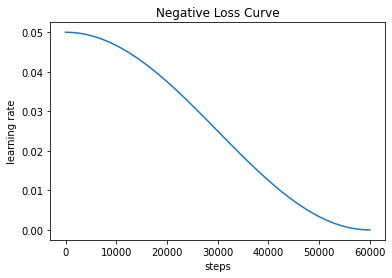

In [19]:
plt.plot(range(steps),lr_decay(range(steps)))
plt.xlabel("steps")
plt.ylabel("learning rate")
plt.title("Negative Loss Curve")

In [20]:
class SimSiam(tf.keras.Model):
    def __init__(self,backbone,projector,predictor):
        super(SimSiam,self).__init__()
        self.backbone = backbone
        self.projector = projector
        self.predictor = predictor
        
    
    @tf.function(jit_compile=True)
    def train_step(self,inputs):
        x1,x2 = inputs
        with tf.GradientTape() as tape:
            z1,z2,p1,p2,loss = self._forward_pass(x1,x2)
            reg_loss = sum(self.backbone.losses)
            reg_loss += sum(self.projector.losses)
            reg_loss += (sum(self.predictor.losses))
            total_loss = loss + reg_loss
        total_params = (
            self.backbone.trainable_variables +
            self.projector.trainable_variables +
            self.predictor.trainable_variables
        )
        grads = tape.gradient(total_loss,total_params)
        self.optimizer.apply_gradients(zip(grads,total_params))
        self.compiled_metrics.update_state([z1,z2],[p2,p1])
        return {m.name: m.result() for m in self.metrics}
    
    def _forward_pass(self,view1,view2):
        f1,f2 = self.backbone(view1), self.backbone(view2)
        z1,z2 = self.projector(f1), self.projector(f2)
        p1, p2 = self.predictor(z1), self.predictor(z2)

        l1 = self.compiled_loss(tf.stop_gradient(z1),p2)
        l2 = self.compiled_loss(tf.stop_gradient(z2),p1)
        loss = l1/2 + l2/2
        return z1,z2,p1,p2,loss

In [21]:
# with strategy.scope():
simsiam = SimSiam(backbone,projector,predictor)

simsiam.compile(
    optimizer = optimizer,
    loss = SimSiamLoss()
)

history = simsiam.fit(train_fused,
                  epochs=C.EPOCHS,
                  steps_per_epoch = PRE_TRAIN_STEPS_PER_EPOCH,
                  callbacks=[mcpt],
                  verbose=1)

Epoch 1/400


2023-01-25 21:34:06.717010: I tensorflow/compiler/xla/service/service.cc:171] XLA service 0x564a0717e710 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-25 21:34:06.717075: I tensorflow/compiler/xla/service/service.cc:179]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2023-01-25 21:34:07.125802: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:210] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-01-25 21:34:10.855803: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


  3/150 [..............................] - ETA: 9s - loss: -0.0547 - proj_std: 0.0152 - pred_std: 0.0131

2023-01-25 21:34:18.453508: I tensorflow/compiler/jit/xla_compilation_cache.cc:363] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 58/150 [==========>...................] - ETA: 25s - loss: -0.6854 - proj_std: 0.0108 - pred_std: 0.0034

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.6965 - proj_std: 0.0107 - pred_std: 0.0033

Cleanup called...


150/150 [==============================] - 63s 280ms/step - loss: -0.8268 - proj_std: 0.0095 - pred_std: 0.0020

Epoch 00001: saving model to ckpts/loss_2023 01 25
Epoch 2/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9230 - proj_std: 0.0084 - pred_std: 0.0010

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9230 - proj_std: 0.0084 - pred_std: 0.0010

Cleanup called...


150/150 [==============================] - 44s 277ms/step - loss: -0.9256 - proj_std: 0.0082 - pred_std: 0.0010

Epoch 00002: saving model to ckpts/loss_2023 01 25
Epoch 3/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.9304 - proj_std: 0.0080 - pred_std: 9.5954e-04

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.9305 - proj_std: 0.0080 - pred_std: 9.5862e-04

Cleanup called...


150/150 [==============================] - 45s 281ms/step - loss: -0.9317 - proj_std: 0.0079 - pred_std: 9.4788e-04

Epoch 00003: saving model to ckpts/loss_2023 01 25
Epoch 4/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9345 - proj_std: 0.0078 - pred_std: 9.3096e-04

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9345 - proj_std: 0.0078 - pred_std: 9.3064e-04

Cleanup called...


150/150 [==============================] - 44s 278ms/step - loss: -0.9353 - proj_std: 0.0077 - pred_std: 9.2797e-04

Epoch 00004: saving model to ckpts/loss_2023 01 25
Epoch 5/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.9369 - proj_std: 0.0076 - pred_std: 9.3224e-04

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9369 - proj_std: 0.0076 - pred_std: 9.3241e-04

Cleanup called...


150/150 [==============================] - 44s 279ms/step - loss: -0.9373 - proj_std: 0.0076 - pred_std: 9.3734e-04

Epoch 00005: saving model to ckpts/loss_2023 01 25
Epoch 6/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9382 - proj_std: 0.0076 - pred_std: 9.5669e-04

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.9382 - proj_std: 0.0076 - pred_std: 9.5713e-04

Cleanup called...


150/150 [==============================] - 44s 276ms/step - loss: -0.9384 - proj_std: 0.0076 - pred_std: 9.6657e-04

Epoch 00006: saving model to ckpts/loss_2023 01 25
Epoch 7/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.9386 - proj_std: 0.0076 - pred_std: 0.0010

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.9386 - proj_std: 0.0076 - pred_std: 0.0010

Cleanup called...


150/150 [==============================] - 44s 277ms/step - loss: -0.9383 - proj_std: 0.0076 - pred_std: 0.0010

Epoch 00007: saving model to ckpts/loss_2023 01 25
Epoch 8/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.9376 - proj_std: 0.0076 - pred_std: 0.0011

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.9375 - proj_std: 0.0076 - pred_std: 0.0011

Cleanup called...


150/150 [==============================] - 44s 279ms/step - loss: -0.9369 - proj_std: 0.0077 - pred_std: 0.0011

Epoch 00008: saving model to ckpts/loss_2023 01 25
Epoch 9/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9348 - proj_std: 0.0078 - pred_std: 0.0012

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9348 - proj_std: 0.0078 - pred_std: 0.0012

Cleanup called...


150/150 [==============================] - 44s 276ms/step - loss: -0.9341 - proj_std: 0.0079 - pred_std: 0.0013

Epoch 00009: saving model to ckpts/loss_2023 01 25
Epoch 10/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9312 - proj_std: 0.0081 - pred_std: 0.0014

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.9311 - proj_std: 0.0081 - pred_std: 0.0014

Cleanup called...


150/150 [==============================] - 45s 283ms/step - loss: -0.9289 - proj_std: 0.0082 - pred_std: 0.0015

Epoch 00010: saving model to ckpts/loss_2023 01 25
Epoch 11/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9228 - proj_std: 0.0086 - pred_std: 0.0018

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9228 - proj_std: 0.0086 - pred_std: 0.0018

Cleanup called...


150/150 [==============================] - 44s 275ms/step - loss: -0.9185 - proj_std: 0.0089 - pred_std: 0.0020

Epoch 00011: saving model to ckpts/loss_2023 01 25
Epoch 12/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.9067 - proj_std: 0.0096 - pred_std: 0.0027

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9065 - proj_std: 0.0096 - pred_std: 0.0027

Cleanup called...


150/150 [==============================] - 44s 279ms/step - loss: -0.8992 - proj_std: 0.0100 - pred_std: 0.0032

Epoch 00012: saving model to ckpts/loss_2023 01 25
Epoch 13/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.8842 - proj_std: 0.0111 - pred_std: 0.0046

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8843 - proj_std: 0.0111 - pred_std: 0.0046

Cleanup called...


150/150 [==============================] - 44s 278ms/step - loss: -0.8832 - proj_std: 0.0113 - pred_std: 0.0051

Epoch 00013: saving model to ckpts/loss_2023 01 25
Epoch 14/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8864 - proj_std: 0.0116 - pred_std: 0.0060

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8865 - proj_std: 0.0116 - pred_std: 0.0060

Cleanup called...


150/150 [==============================] - 45s 282ms/step - loss: -0.8900 - proj_std: 0.0115 - pred_std: 0.0061

Epoch 00014: saving model to ckpts/loss_2023 01 25
Epoch 15/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.8979 - proj_std: 0.0114 - pred_std: 0.0066

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8979 - proj_std: 0.0114 - pred_std: 0.0066

Cleanup called...


150/150 [==============================] - 44s 276ms/step - loss: -0.9001 - proj_std: 0.0113 - pred_std: 0.0065

Epoch 00015: saving model to ckpts/loss_2023 01 25
Epoch 16/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.9049 - proj_std: 0.0112 - pred_std: 0.0066

Cleanup called...


 61/150 [===========>..................] - ETA: 26s - loss: -0.9048 - proj_std: 0.0112 - pred_std: 0.0066

Cleanup called...


150/150 [==============================] - 45s 281ms/step - loss: -0.9055 - proj_std: 0.0111 - pred_std: 0.0065

Epoch 00016: saving model to ckpts/loss_2023 01 25
Epoch 17/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9070 - proj_std: 0.0111 - pred_std: 0.0067

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.9072 - proj_std: 0.0111 - pred_std: 0.0067

Cleanup called...


150/150 [==============================] - 44s 276ms/step - loss: -0.9070 - proj_std: 0.0111 - pred_std: 0.0067

Epoch 00017: saving model to ckpts/loss_2023 01 25
Epoch 18/400
 56/150 [==========>...................] - ETA: 28s - loss: -0.9069 - proj_std: 0.0112 - pred_std: 0.0069

Cleanup called...


 61/150 [===========>..................] - ETA: 26s - loss: -0.9068 - proj_std: 0.0112 - pred_std: 0.0069

Cleanup called...


150/150 [==============================] - 45s 285ms/step - loss: -0.9073 - proj_std: 0.0112 - pred_std: 0.0069

Epoch 00018: saving model to ckpts/loss_2023 01 25
Epoch 19/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9080 - proj_std: 0.0112 - pred_std: 0.0070

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9082 - proj_std: 0.0112 - pred_std: 0.0070

Cleanup called...


150/150 [==============================] - 44s 276ms/step - loss: -0.9093 - proj_std: 0.0112 - pred_std: 0.0070

Epoch 00019: saving model to ckpts/loss_2023 01 25
Epoch 20/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9114 - proj_std: 0.0112 - pred_std: 0.0073

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9114 - proj_std: 0.0112 - pred_std: 0.0073

Cleanup called...


150/150 [==============================] - 44s 279ms/step - loss: -0.9128 - proj_std: 0.0112 - pred_std: 0.0072

Epoch 00020: saving model to ckpts/loss_2023 01 25
Epoch 21/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.9153 - proj_std: 0.0111 - pred_std: 0.0073

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9153 - proj_std: 0.0111 - pred_std: 0.0073

Cleanup called...


150/150 [==============================] - 44s 276ms/step - loss: -0.9161 - proj_std: 0.0111 - pred_std: 0.0073

Epoch 00021: saving model to ckpts/loss_2023 01 25
Epoch 22/400
 56/150 [==========>...................] - ETA: 28s - loss: -0.9185 - proj_std: 0.0110 - pred_std: 0.0073

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.9184 - proj_std: 0.0110 - pred_std: 0.0073

Cleanup called...


150/150 [==============================] - 45s 283ms/step - loss: -0.9190 - proj_std: 0.0110 - pred_std: 0.0073

Epoch 00022: saving model to ckpts/loss_2023 01 25
Epoch 23/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.9206 - proj_std: 0.0109 - pred_std: 0.0073

Cleanup called...


 61/150 [===========>..................] - ETA: 26s - loss: -0.9207 - proj_std: 0.0109 - pred_std: 0.0073

Cleanup called...


150/150 [==============================] - 45s 282ms/step - loss: -0.9211 - proj_std: 0.0109 - pred_std: 0.0072

Epoch 00023: saving model to ckpts/loss_2023 01 25
Epoch 24/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.9225 - proj_std: 0.0109 - pred_std: 0.0074

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9226 - proj_std: 0.0109 - pred_std: 0.0073

Cleanup called...


150/150 [==============================] - 44s 278ms/step - loss: -0.9226 - proj_std: 0.0108 - pred_std: 0.0073

Epoch 00024: saving model to ckpts/loss_2023 01 25
Epoch 25/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9227 - proj_std: 0.0108 - pred_std: 0.0073

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9227 - proj_std: 0.0108 - pred_std: 0.0073

Cleanup called...


150/150 [==============================] - 44s 277ms/step - loss: -0.9229 - proj_std: 0.0108 - pred_std: 0.0073

Epoch 00025: saving model to ckpts/loss_2023 01 25
Epoch 26/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.9233 - proj_std: 0.0108 - pred_std: 0.0073

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.9232 - proj_std: 0.0108 - pred_std: 0.0073

Cleanup called...


150/150 [==============================] - 45s 283ms/step - loss: -0.9230 - proj_std: 0.0108 - pred_std: 0.0073

Epoch 00026: saving model to ckpts/loss_2023 01 25
Epoch 27/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9230 - proj_std: 0.0108 - pred_std: 0.0073

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9230 - proj_std: 0.0108 - pred_std: 0.0073

Cleanup called...


150/150 [==============================] - 44s 276ms/step - loss: -0.9230 - proj_std: 0.0108 - pred_std: 0.0073

Epoch 00027: saving model to ckpts/loss_2023 01 25
Epoch 28/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9231 - proj_std: 0.0109 - pred_std: 0.0074

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9230 - proj_std: 0.0109 - pred_std: 0.0074

Cleanup called...


150/150 [==============================] - 45s 280ms/step - loss: -0.9228 - proj_std: 0.0109 - pred_std: 0.0074

Epoch 00028: saving model to ckpts/loss_2023 01 25
Epoch 29/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9229 - proj_std: 0.0109 - pred_std: 0.0075

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9229 - proj_std: 0.0109 - pred_std: 0.0075

Cleanup called...


150/150 [==============================] - 44s 277ms/step - loss: -0.9228 - proj_std: 0.0109 - pred_std: 0.0075

Epoch 00029: saving model to ckpts/loss_2023 01 25
Epoch 30/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9230 - proj_std: 0.0109 - pred_std: 0.0074

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9232 - proj_std: 0.0109 - pred_std: 0.0074

Cleanup called...


150/150 [==============================] - 44s 277ms/step - loss: -0.9229 - proj_std: 0.0109 - pred_std: 0.0075

Epoch 00030: saving model to ckpts/loss_2023 01 25
Epoch 31/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.9231 - proj_std: 0.0110 - pred_std: 0.0076

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.9230 - proj_std: 0.0110 - pred_std: 0.0076

Cleanup called...


150/150 [==============================] - 46s 284ms/step - loss: -0.9230 - proj_std: 0.0110 - pred_std: 0.0076

Epoch 00031: saving model to ckpts/loss_2023 01 25
Epoch 32/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9231 - proj_std: 0.0110 - pred_std: 0.0076

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9233 - proj_std: 0.0110 - pred_std: 0.0076

Cleanup called...


150/150 [==============================] - 44s 278ms/step - loss: -0.9235 - proj_std: 0.0110 - pred_std: 0.0076

Epoch 00032: saving model to ckpts/loss_2023 01 25
Epoch 33/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.9236 - proj_std: 0.0110 - pred_std: 0.0076

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.9235 - proj_std: 0.0110 - pred_std: 0.0076

Cleanup called...


150/150 [==============================] - 45s 282ms/step - loss: -0.9237 - proj_std: 0.0110 - pred_std: 0.0077

Epoch 00033: saving model to ckpts/loss_2023 01 25
Epoch 34/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9235 - proj_std: 0.0110 - pred_std: 0.0077

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9236 - proj_std: 0.0110 - pred_std: 0.0077

Cleanup called...


150/150 [==============================] - 45s 279ms/step - loss: -0.9240 - proj_std: 0.0110 - pred_std: 0.0077

Epoch 00034: saving model to ckpts/loss_2023 01 25
Epoch 35/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.9244 - proj_std: 0.0111 - pred_std: 0.0078

Cleanup called...


 61/150 [===========>..................] - ETA: 26s - loss: -0.9241 - proj_std: 0.0110 - pred_std: 0.0078

Cleanup called...


150/150 [==============================] - 45s 282ms/step - loss: -0.9240 - proj_std: 0.0110 - pred_std: 0.0077

Epoch 00035: saving model to ckpts/loss_2023 01 25
Epoch 36/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9240 - proj_std: 0.0110 - pred_std: 0.0078

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9239 - proj_std: 0.0110 - pred_std: 0.0078

Cleanup called...


150/150 [==============================] - 44s 276ms/step - loss: -0.9240 - proj_std: 0.0111 - pred_std: 0.0078

Epoch 00036: saving model to ckpts/loss_2023 01 25
Epoch 37/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9237 - proj_std: 0.0111 - pred_std: 0.0079

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.9238 - proj_std: 0.0111 - pred_std: 0.0079

Cleanup called...


150/150 [==============================] - 45s 279ms/step - loss: -0.9237 - proj_std: 0.0111 - pred_std: 0.0079

Epoch 00037: saving model to ckpts/loss_2023 01 25
Epoch 38/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9234 - proj_std: 0.0112 - pred_std: 0.0080

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9236 - proj_std: 0.0112 - pred_std: 0.0080

Cleanup called...


150/150 [==============================] - 45s 278ms/step - loss: -0.9234 - proj_std: 0.0112 - pred_std: 0.0079

Epoch 00038: saving model to ckpts/loss_2023 01 25
Epoch 39/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9238 - proj_std: 0.0112 - pred_std: 0.0080

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9239 - proj_std: 0.0112 - pred_std: 0.0080

Cleanup called...


150/150 [==============================] - 45s 281ms/step - loss: -0.9233 - proj_std: 0.0112 - pred_std: 0.0080

Epoch 00039: saving model to ckpts/loss_2023 01 25
Epoch 40/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9229 - proj_std: 0.0112 - pred_std: 0.0080

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9230 - proj_std: 0.0112 - pred_std: 0.0080

Cleanup called...


150/150 [==============================] - 44s 276ms/step - loss: -0.9226 - proj_std: 0.0112 - pred_std: 0.0080

Epoch 00040: saving model to ckpts/loss_2023 01 25
Epoch 41/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9221 - proj_std: 0.0113 - pred_std: 0.0081

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.9222 - proj_std: 0.0113 - pred_std: 0.0081

Cleanup called...


150/150 [==============================] - 45s 280ms/step - loss: -0.9219 - proj_std: 0.0113 - pred_std: 0.0081

Epoch 00041: saving model to ckpts/loss_2023 01 25
Epoch 42/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9218 - proj_std: 0.0114 - pred_std: 0.0082

Cleanup called...


 61/150 [===========>..................] - ETA: 27s - loss: -0.9218 - proj_std: 0.0114 - pred_std: 0.0082

Cleanup called...


150/150 [==============================] - 45s 281ms/step - loss: -0.9217 - proj_std: 0.0114 - pred_std: 0.0082

Epoch 00042: saving model to ckpts/loss_2023 01 25
Epoch 43/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9212 - proj_std: 0.0114 - pred_std: 0.0082

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9213 - proj_std: 0.0114 - pred_std: 0.0082

Cleanup called...


150/150 [==============================] - 45s 278ms/step - loss: -0.9211 - proj_std: 0.0114 - pred_std: 0.0083

Epoch 00043: saving model to ckpts/loss_2023 01 25
Epoch 44/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9203 - proj_std: 0.0115 - pred_std: 0.0083

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.9202 - proj_std: 0.0115 - pred_std: 0.0083

Cleanup called...


150/150 [==============================] - 44s 281ms/step - loss: -0.9202 - proj_std: 0.0115 - pred_std: 0.0083

Epoch 00044: saving model to ckpts/loss_2023 01 25
Epoch 45/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.9196 - proj_std: 0.0115 - pred_std: 0.0084

Cleanup called...


 61/150 [===========>..................] - ETA: 27s - loss: -0.9196 - proj_std: 0.0115 - pred_std: 0.0084

Cleanup called...


150/150 [==============================] - 45s 285ms/step - loss: -0.9193 - proj_std: 0.0116 - pred_std: 0.0084

Epoch 00045: saving model to ckpts/loss_2023 01 25
Epoch 46/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9183 - proj_std: 0.0116 - pred_std: 0.0084

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9182 - proj_std: 0.0116 - pred_std: 0.0084

Cleanup called...


150/150 [==============================] - 44s 276ms/step - loss: -0.9180 - proj_std: 0.0116 - pred_std: 0.0084

Epoch 00046: saving model to ckpts/loss_2023 01 25
Epoch 47/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9169 - proj_std: 0.0118 - pred_std: 0.0086

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9168 - proj_std: 0.0118 - pred_std: 0.0086

Cleanup called...


150/150 [==============================] - 44s 279ms/step - loss: -0.9169 - proj_std: 0.0117 - pred_std: 0.0085

Epoch 00047: saving model to ckpts/loss_2023 01 25
Epoch 48/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.9164 - proj_std: 0.0118 - pred_std: 0.0086

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9165 - proj_std: 0.0118 - pred_std: 0.0086

Cleanup called...


150/150 [==============================] - 44s 278ms/step - loss: -0.9156 - proj_std: 0.0118 - pred_std: 0.0086

Epoch 00048: saving model to ckpts/loss_2023 01 25
Epoch 49/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9141 - proj_std: 0.0120 - pred_std: 0.0087

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9140 - proj_std: 0.0120 - pred_std: 0.0087

Cleanup called...


150/150 [==============================] - 45s 283ms/step - loss: -0.9138 - proj_std: 0.0120 - pred_std: 0.0087

Epoch 00049: saving model to ckpts/loss_2023 01 25
Epoch 50/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9118 - proj_std: 0.0121 - pred_std: 0.0088

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9119 - proj_std: 0.0121 - pred_std: 0.0088

Cleanup called...


150/150 [==============================] - 45s 281ms/step - loss: -0.9120 - proj_std: 0.0121 - pred_std: 0.0088

Epoch 00050: saving model to ckpts/loss_2023 01 25
Epoch 51/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9103 - proj_std: 0.0122 - pred_std: 0.0089

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9102 - proj_std: 0.0122 - pred_std: 0.0089

Cleanup called...


150/150 [==============================] - 45s 282ms/step - loss: -0.9100 - proj_std: 0.0122 - pred_std: 0.0089

Epoch 00051: saving model to ckpts/loss_2023 01 25
Epoch 52/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9093 - proj_std: 0.0123 - pred_std: 0.0090

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9092 - proj_std: 0.0123 - pred_std: 0.0090

Cleanup called...


150/150 [==============================] - 45s 280ms/step - loss: -0.9085 - proj_std: 0.0123 - pred_std: 0.0090

Epoch 00052: saving model to ckpts/loss_2023 01 25
Epoch 53/400
 58/150 [==========>...................] - ETA: 28s - loss: -0.9074 - proj_std: 0.0125 - pred_std: 0.0092

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.9073 - proj_std: 0.0125 - pred_std: 0.0092

Cleanup called...


150/150 [==============================] - 45s 284ms/step - loss: -0.9062 - proj_std: 0.0125 - pred_std: 0.0092

Epoch 00053: saving model to ckpts/loss_2023 01 25
Epoch 54/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.9056 - proj_std: 0.0125 - pred_std: 0.0092

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.9055 - proj_std: 0.0125 - pred_std: 0.0093

Cleanup called...


150/150 [==============================] - 44s 277ms/step - loss: -0.9047 - proj_std: 0.0126 - pred_std: 0.0093

Epoch 00054: saving model to ckpts/loss_2023 01 25
Epoch 55/400
 56/150 [==========>...................] - ETA: 27s - loss: -0.9025 - proj_std: 0.0127 - pred_std: 0.0094

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.9025 - proj_std: 0.0127 - pred_std: 0.0095

Cleanup called...


150/150 [==============================] - 46s 282ms/step - loss: -0.9023 - proj_std: 0.0128 - pred_std: 0.0095

Epoch 00055: saving model to ckpts/loss_2023 01 25
Epoch 56/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.9015 - proj_std: 0.0129 - pred_std: 0.0096

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.9013 - proj_std: 0.0129 - pred_std: 0.0097

Cleanup called...


150/150 [==============================] - 44s 278ms/step - loss: -0.9009 - proj_std: 0.0129 - pred_std: 0.0096

Epoch 00056: saving model to ckpts/loss_2023 01 25
Epoch 57/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.8981 - proj_std: 0.0131 - pred_std: 0.0098

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.8980 - proj_std: 0.0131 - pred_std: 0.0098

Cleanup called...


150/150 [==============================] - 45s 286ms/step - loss: -0.8982 - proj_std: 0.0130 - pred_std: 0.0098

Epoch 00057: saving model to ckpts/loss_2023 01 25
Epoch 58/400
 57/150 [==========>...................] - ETA: 25s - loss: -0.8964 - proj_std: 0.0131 - pred_std: 0.0098

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8964 - proj_std: 0.0131 - pred_std: 0.0098

Cleanup called...


150/150 [==============================] - 44s 278ms/step - loss: -0.8959 - proj_std: 0.0132 - pred_std: 0.0099

Epoch 00058: saving model to ckpts/loss_2023 01 25
Epoch 59/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.8934 - proj_std: 0.0134 - pred_std: 0.0101

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8935 - proj_std: 0.0134 - pred_std: 0.0101

Cleanup called...


150/150 [==============================] - 45s 282ms/step - loss: -0.8924 - proj_std: 0.0134 - pred_std: 0.0101

Epoch 00059: saving model to ckpts/loss_2023 01 25
Epoch 60/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.8907 - proj_std: 0.0136 - pred_std: 0.0104

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8905 - proj_std: 0.0136 - pred_std: 0.0104

Cleanup called...


150/150 [==============================] - 44s 276ms/step - loss: -0.8891 - proj_std: 0.0137 - pred_std: 0.0104

Epoch 00060: saving model to ckpts/loss_2023 01 25
Epoch 61/400
 57/150 [==========>...................] - ETA: 25s - loss: -0.8875 - proj_std: 0.0137 - pred_std: 0.0104

Cleanup called...


 61/150 [===========>..................] - ETA: 24s - loss: -0.8875 - proj_std: 0.0137 - pred_std: 0.0104

Cleanup called...


150/150 [==============================] - 45s 278ms/step - loss: -0.8862 - proj_std: 0.0138 - pred_std: 0.0106

Epoch 00061: saving model to ckpts/loss_2023 01 25
Epoch 62/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8820 - proj_std: 0.0141 - pred_std: 0.0108

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8820 - proj_std: 0.0141 - pred_std: 0.0108

Cleanup called...


150/150 [==============================] - 44s 278ms/step - loss: -0.8824 - proj_std: 0.0141 - pred_std: 0.0108

Epoch 00062: saving model to ckpts/loss_2023 01 25
Epoch 63/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.8806 - proj_std: 0.0143 - pred_std: 0.0110

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8808 - proj_std: 0.0143 - pred_std: 0.0110

Cleanup called...


150/150 [==============================] - 45s 280ms/step - loss: -0.8796 - proj_std: 0.0143 - pred_std: 0.0111

Epoch 00063: saving model to ckpts/loss_2023 01 25
Epoch 64/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.8763 - proj_std: 0.0145 - pred_std: 0.0113

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.8761 - proj_std: 0.0145 - pred_std: 0.0113

Cleanup called...


150/150 [==============================] - 45s 282ms/step - loss: -0.8770 - proj_std: 0.0145 - pred_std: 0.0113

Epoch 00064: saving model to ckpts/loss_2023 01 25
Epoch 65/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8767 - proj_std: 0.0146 - pred_std: 0.0115

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8765 - proj_std: 0.0146 - pred_std: 0.0115

Cleanup called...


150/150 [==============================] - 45s 285ms/step - loss: -0.8747 - proj_std: 0.0147 - pred_std: 0.0115

Epoch 00065: saving model to ckpts/loss_2023 01 25
Epoch 66/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8712 - proj_std: 0.0149 - pred_std: 0.0118

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8713 - proj_std: 0.0149 - pred_std: 0.0118

Cleanup called...


150/150 [==============================] - 44s 277ms/step - loss: -0.8704 - proj_std: 0.0150 - pred_std: 0.0118

Epoch 00066: saving model to ckpts/loss_2023 01 25
Epoch 67/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.8686 - proj_std: 0.0152 - pred_std: 0.0121

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.8684 - proj_std: 0.0151 - pred_std: 0.0121

Cleanup called...


150/150 [==============================] - 45s 284ms/step - loss: -0.8672 - proj_std: 0.0152 - pred_std: 0.0121

Epoch 00067: saving model to ckpts/loss_2023 01 25
Epoch 68/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.8645 - proj_std: 0.0154 - pred_std: 0.0124

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8645 - proj_std: 0.0154 - pred_std: 0.0124

Cleanup called...


150/150 [==============================] - 44s 279ms/step - loss: -0.8640 - proj_std: 0.0154 - pred_std: 0.0124

Epoch 00068: saving model to ckpts/loss_2023 01 25
Epoch 69/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8634 - proj_std: 0.0156 - pred_std: 0.0126

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8634 - proj_std: 0.0156 - pred_std: 0.0126

Cleanup called...


150/150 [==============================] - 46s 285ms/step - loss: -0.8610 - proj_std: 0.0156 - pred_std: 0.0127

Epoch 00069: saving model to ckpts/loss_2023 01 25
Epoch 70/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.8588 - proj_std: 0.0159 - pred_std: 0.0129

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8586 - proj_std: 0.0159 - pred_std: 0.0129

Cleanup called...


150/150 [==============================] - 44s 277ms/step - loss: -0.8577 - proj_std: 0.0159 - pred_std: 0.0130

Epoch 00070: saving model to ckpts/loss_2023 01 25
Epoch 71/400
 58/150 [==========>...................] - ETA: 28s - loss: -0.8579 - proj_std: 0.0160 - pred_std: 0.0131

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.8575 - proj_std: 0.0160 - pred_std: 0.0131

Cleanup called...


150/150 [==============================] - 45s 286ms/step - loss: -0.8559 - proj_std: 0.0160 - pred_std: 0.0131

Epoch 00071: saving model to ckpts/loss_2023 01 25
Epoch 72/400
 58/150 [==========>...................] - ETA: 25s - loss: -0.8529 - proj_std: 0.0163 - pred_std: 0.0135

Cleanup called...


 61/150 [===========>..................] - ETA: 24s - loss: -0.8524 - proj_std: 0.0163 - pred_std: 0.0135

Cleanup called...


150/150 [==============================] - 45s 276ms/step - loss: -0.8515 - proj_std: 0.0164 - pred_std: 0.0136

Epoch 00072: saving model to ckpts/loss_2023 01 25
Epoch 73/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.8526 - proj_std: 0.0164 - pred_std: 0.0137

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.8530 - proj_std: 0.0164 - pred_std: 0.0137

Cleanup called...


150/150 [==============================] - 45s 284ms/step - loss: -0.8506 - proj_std: 0.0165 - pred_std: 0.0138

Epoch 00073: saving model to ckpts/loss_2023 01 25
Epoch 74/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8501 - proj_std: 0.0165 - pred_std: 0.0138

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8499 - proj_std: 0.0165 - pred_std: 0.0138

Cleanup called...


150/150 [==============================] - 45s 280ms/step - loss: -0.8480 - proj_std: 0.0167 - pred_std: 0.0140

Epoch 00074: saving model to ckpts/loss_2023 01 25
Epoch 75/400
 59/150 [==========>...................] - ETA: 26s - loss: -0.8472 - proj_std: 0.0168 - pred_std: 0.0142

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8468 - proj_std: 0.0168 - pred_std: 0.0142

Cleanup called...


150/150 [==============================] - 44s 280ms/step - loss: -0.8460 - proj_std: 0.0169 - pred_std: 0.0142

Epoch 00075: saving model to ckpts/loss_2023 01 25
Epoch 76/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.8469 - proj_std: 0.0169 - pred_std: 0.0143

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.8469 - proj_std: 0.0169 - pred_std: 0.0143

Cleanup called...


150/150 [==============================] - 45s 277ms/step - loss: -0.8462 - proj_std: 0.0170 - pred_std: 0.0144

Epoch 00076: saving model to ckpts/loss_2023 01 25
Epoch 77/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.8423 - proj_std: 0.0171 - pred_std: 0.0145

Cleanup called...


 61/150 [===========>..................] - ETA: 26s - loss: -0.8421 - proj_std: 0.0171 - pred_std: 0.0145

Cleanup called...


150/150 [==============================] - 45s 280ms/step - loss: -0.8404 - proj_std: 0.0172 - pred_std: 0.0146

Epoch 00077: saving model to ckpts/loss_2023 01 25
Epoch 78/400
 56/150 [==========>...................] - ETA: 27s - loss: -0.8400 - proj_std: 0.0173 - pred_std: 0.0148

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8405 - proj_std: 0.0173 - pred_std: 0.0148

Cleanup called...


150/150 [==============================] - 45s 281ms/step - loss: -0.8396 - proj_std: 0.0174 - pred_std: 0.0149

Epoch 00078: saving model to ckpts/loss_2023 01 25
Epoch 79/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.8372 - proj_std: 0.0175 - pred_std: 0.0151

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.8373 - proj_std: 0.0175 - pred_std: 0.0151

Cleanup called...


150/150 [==============================] - 45s 285ms/step - loss: -0.8378 - proj_std: 0.0175 - pred_std: 0.0151

Epoch 00079: saving model to ckpts/loss_2023 01 25
Epoch 80/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8355 - proj_std: 0.0177 - pred_std: 0.0154

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8356 - proj_std: 0.0177 - pred_std: 0.0154

Cleanup called...


150/150 [==============================] - 45s 282ms/step - loss: -0.8356 - proj_std: 0.0177 - pred_std: 0.0154

Epoch 00080: saving model to ckpts/loss_2023 01 25
Epoch 81/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.8335 - proj_std: 0.0178 - pred_std: 0.0156

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8331 - proj_std: 0.0178 - pred_std: 0.0156

Cleanup called...


150/150 [==============================] - 44s 274ms/step - loss: -0.8340 - proj_std: 0.0178 - pred_std: 0.0156

Epoch 00081: saving model to ckpts/loss_2023 01 25
Epoch 82/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.8336 - proj_std: 0.0179 - pred_std: 0.0157

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8339 - proj_std: 0.0179 - pred_std: 0.0157

Cleanup called...


150/150 [==============================] - 45s 277ms/step - loss: -0.8330 - proj_std: 0.0180 - pred_std: 0.0158

Epoch 00082: saving model to ckpts/loss_2023 01 25
Epoch 83/400
 58/150 [==========>...................] - ETA: 28s - loss: -0.8314 - proj_std: 0.0181 - pred_std: 0.0159

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.8316 - proj_std: 0.0181 - pred_std: 0.0160

Cleanup called...


150/150 [==============================] - 44s 279ms/step - loss: -0.8307 - proj_std: 0.0181 - pred_std: 0.0160

Epoch 00083: saving model to ckpts/loss_2023 01 25
Epoch 84/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.8319 - proj_std: 0.0182 - pred_std: 0.0162

Cleanup called...


 61/150 [===========>..................] - ETA: 24s - loss: -0.8316 - proj_std: 0.0183 - pred_std: 0.0162

Cleanup called...


150/150 [==============================] - 44s 273ms/step - loss: -0.8299 - proj_std: 0.0183 - pred_std: 0.0162

Epoch 00084: saving model to ckpts/loss_2023 01 25
Epoch 85/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.8295 - proj_std: 0.0184 - pred_std: 0.0163

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8294 - proj_std: 0.0184 - pred_std: 0.0163

Cleanup called...


150/150 [==============================] - 44s 275ms/step - loss: -0.8298 - proj_std: 0.0183 - pred_std: 0.0163

Epoch 00085: saving model to ckpts/loss_2023 01 25
Epoch 86/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.8279 - proj_std: 0.0185 - pred_std: 0.0165

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8279 - proj_std: 0.0185 - pred_std: 0.0165

Cleanup called...


150/150 [==============================] - 45s 279ms/step - loss: -0.8285 - proj_std: 0.0185 - pred_std: 0.0165

Epoch 00086: saving model to ckpts/loss_2023 01 25
Epoch 87/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8275 - proj_std: 0.0186 - pred_std: 0.0167

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8276 - proj_std: 0.0186 - pred_std: 0.0167

Cleanup called...


150/150 [==============================] - 46s 281ms/step - loss: -0.8264 - proj_std: 0.0186 - pred_std: 0.0167

Epoch 00087: saving model to ckpts/loss_2023 01 25
Epoch 88/400
 59/150 [==========>...................] - ETA: 25s - loss: -0.8265 - proj_std: 0.0188 - pred_std: 0.0170

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8262 - proj_std: 0.0188 - pred_std: 0.0170

Cleanup called...


150/150 [==============================] - 44s 275ms/step - loss: -0.8263 - proj_std: 0.0187 - pred_std: 0.0169

Epoch 00088: saving model to ckpts/loss_2023 01 25
Epoch 89/400
 56/150 [==========>...................] - ETA: 28s - loss: -0.8266 - proj_std: 0.0188 - pred_std: 0.0170

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.8269 - proj_std: 0.0188 - pred_std: 0.0170

Cleanup called...


150/150 [==============================] - 45s 282ms/step - loss: -0.8274 - proj_std: 0.0187 - pred_std: 0.0169

Epoch 00089: saving model to ckpts/loss_2023 01 25
Epoch 90/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8270 - proj_std: 0.0188 - pred_std: 0.0170

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8267 - proj_std: 0.0188 - pred_std: 0.0170

Cleanup called...


150/150 [==============================] - 45s 281ms/step - loss: -0.8282 - proj_std: 0.0188 - pred_std: 0.0170

Epoch 00090: saving model to ckpts/loss_2023 01 25
Epoch 91/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.8260 - proj_std: 0.0188 - pred_std: 0.0170

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8260 - proj_std: 0.0188 - pred_std: 0.0170

Cleanup called...


150/150 [==============================] - 44s 279ms/step - loss: -0.8248 - proj_std: 0.0189 - pred_std: 0.0171

Epoch 00091: saving model to ckpts/loss_2023 01 25
Epoch 92/400
 57/150 [==========>...................] - ETA: 25s - loss: -0.8229 - proj_std: 0.0190 - pred_std: 0.0173

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8231 - proj_std: 0.0190 - pred_std: 0.0173

Cleanup called...


150/150 [==============================] - 45s 277ms/step - loss: -0.8252 - proj_std: 0.0189 - pred_std: 0.0172

Epoch 00092: saving model to ckpts/loss_2023 01 25
Epoch 93/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8270 - proj_std: 0.0189 - pred_std: 0.0172

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8264 - proj_std: 0.0189 - pred_std: 0.0172

Cleanup called...


150/150 [==============================] - 46s 282ms/step - loss: -0.8256 - proj_std: 0.0190 - pred_std: 0.0173

Epoch 00093: saving model to ckpts/loss_2023 01 25
Epoch 94/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8271 - proj_std: 0.0190 - pred_std: 0.0173

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8270 - proj_std: 0.0190 - pred_std: 0.0173

Cleanup called...


150/150 [==============================] - 45s 283ms/step - loss: -0.8268 - proj_std: 0.0190 - pred_std: 0.0173

Epoch 00094: saving model to ckpts/loss_2023 01 25
Epoch 95/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.8262 - proj_std: 0.0191 - pred_std: 0.0175

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8263 - proj_std: 0.0191 - pred_std: 0.0175

Cleanup called...


150/150 [==============================] - 45s 278ms/step - loss: -0.8266 - proj_std: 0.0191 - pred_std: 0.0175

Epoch 00095: saving model to ckpts/loss_2023 01 25
Epoch 96/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.8272 - proj_std: 0.0190 - pred_std: 0.0174

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.8278 - proj_std: 0.0190 - pred_std: 0.0174

Cleanup called...


150/150 [==============================] - 44s 278ms/step - loss: -0.8256 - proj_std: 0.0192 - pred_std: 0.0176

Epoch 00096: saving model to ckpts/loss_2023 01 25
Epoch 97/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.8265 - proj_std: 0.0192 - pred_std: 0.0176

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8268 - proj_std: 0.0192 - pred_std: 0.0177

Cleanup called...


150/150 [==============================] - 45s 278ms/step - loss: -0.8264 - proj_std: 0.0192 - pred_std: 0.0176

Epoch 00097: saving model to ckpts/loss_2023 01 25
Epoch 98/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8266 - proj_std: 0.0192 - pred_std: 0.0176

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8260 - proj_std: 0.0192 - pred_std: 0.0176

Cleanup called...


150/150 [==============================] - 46s 285ms/step - loss: -0.8255 - proj_std: 0.0192 - pred_std: 0.0177

Epoch 00098: saving model to ckpts/loss_2023 01 25
Epoch 99/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.8253 - proj_std: 0.0193 - pred_std: 0.0178

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8258 - proj_std: 0.0193 - pred_std: 0.0178

Cleanup called...


150/150 [==============================] - 44s 276ms/step - loss: -0.8239 - proj_std: 0.0193 - pred_std: 0.0178

Epoch 00099: saving model to ckpts/loss_2023 01 25
Epoch 100/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.8239 - proj_std: 0.0194 - pred_std: 0.0179

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.8244 - proj_std: 0.0194 - pred_std: 0.0179

Cleanup called...


150/150 [==============================] - 45s 282ms/step - loss: -0.8253 - proj_std: 0.0194 - pred_std: 0.0179

Epoch 00100: saving model to ckpts/loss_2023 01 25
Epoch 101/400
 59/150 [==========>...................] - ETA: 25s - loss: -0.8286 - proj_std: 0.0194 - pred_std: 0.0180

Cleanup called...


 60/150 [===========>..................] - ETA: 24s - loss: -0.8286 - proj_std: 0.0194 - pred_std: 0.0180

Cleanup called...


150/150 [==============================] - 45s 279ms/step - loss: -0.8267 - proj_std: 0.0194 - pred_std: 0.0179

Epoch 00101: saving model to ckpts/loss_2023 01 25
Epoch 102/400
 59/150 [==========>...................] - ETA: 26s - loss: -0.8244 - proj_std: 0.0194 - pred_std: 0.0179

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8238 - proj_std: 0.0194 - pred_std: 0.0179

Cleanup called...


150/150 [==============================] - 45s 278ms/step - loss: -0.8254 - proj_std: 0.0194 - pred_std: 0.0180

Epoch 00102: saving model to ckpts/loss_2023 01 25
Epoch 103/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.8302 - proj_std: 0.0193 - pred_std: 0.0179

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8300 - proj_std: 0.0193 - pred_std: 0.0179

Cleanup called...


150/150 [==============================] - 46s 281ms/step - loss: -0.8272 - proj_std: 0.0194 - pred_std: 0.0179

Epoch 00103: saving model to ckpts/loss_2023 01 25
Epoch 104/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8267 - proj_std: 0.0195 - pred_std: 0.0181

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8268 - proj_std: 0.0195 - pred_std: 0.0181

Cleanup called...


150/150 [==============================] - 46s 284ms/step - loss: -0.8280 - proj_std: 0.0195 - pred_std: 0.0181

Epoch 00104: saving model to ckpts/loss_2023 01 25
Epoch 105/400
 57/150 [==========>...................] - ETA: 25s - loss: -0.8277 - proj_std: 0.0195 - pred_std: 0.0181

Cleanup called...


 60/150 [===========>..................] - ETA: 24s - loss: -0.8279 - proj_std: 0.0195 - pred_std: 0.0181

Cleanup called...


150/150 [==============================] - 45s 276ms/step - loss: -0.8297 - proj_std: 0.0194 - pred_std: 0.0181

Epoch 00105: saving model to ckpts/loss_2023 01 25
Epoch 106/400
 58/150 [==========>...................] - ETA: 25s - loss: -0.8282 - proj_std: 0.0194 - pred_std: 0.0180

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8280 - proj_std: 0.0195 - pred_std: 0.0181

Cleanup called...


150/150 [==============================] - 46s 279ms/step - loss: -0.8268 - proj_std: 0.0195 - pred_std: 0.0181

Epoch 00106: saving model to ckpts/loss_2023 01 25
Epoch 107/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.8281 - proj_std: 0.0195 - pred_std: 0.0181

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.8282 - proj_std: 0.0195 - pred_std: 0.0181

Cleanup called...


150/150 [==============================] - 45s 279ms/step - loss: -0.8304 - proj_std: 0.0194 - pred_std: 0.0181

Epoch 00107: saving model to ckpts/loss_2023 01 25
Epoch 108/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8284 - proj_std: 0.0194 - pred_std: 0.0180

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8286 - proj_std: 0.0194 - pred_std: 0.0180

Cleanup called...


150/150 [==============================] - 45s 281ms/step - loss: -0.8297 - proj_std: 0.0195 - pred_std: 0.0181

Epoch 00108: saving model to ckpts/loss_2023 01 25
Epoch 109/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.8295 - proj_std: 0.0196 - pred_std: 0.0182

Cleanup called...


 61/150 [===========>..................] - ETA: 27s - loss: -0.8302 - proj_std: 0.0195 - pred_std: 0.0182

Cleanup called...


150/150 [==============================] - 45s 286ms/step - loss: -0.8301 - proj_std: 0.0195 - pred_std: 0.0182

Epoch 00109: saving model to ckpts/loss_2023 01 25
Epoch 110/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8278 - proj_std: 0.0195 - pred_std: 0.0182

Cleanup called...


 61/150 [===========>..................] - ETA: 26s - loss: -0.8277 - proj_std: 0.0195 - pred_std: 0.0182

Cleanup called...


150/150 [==============================] - 45s 282ms/step - loss: -0.8306 - proj_std: 0.0195 - pred_std: 0.0182

Epoch 00110: saving model to ckpts/loss_2023 01 25
Epoch 111/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.8283 - proj_std: 0.0196 - pred_std: 0.0182

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.8277 - proj_std: 0.0196 - pred_std: 0.0182

Cleanup called...


150/150 [==============================] - 45s 277ms/step - loss: -0.8291 - proj_std: 0.0195 - pred_std: 0.0182

Epoch 00111: saving model to ckpts/loss_2023 01 25
Epoch 112/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.8331 - proj_std: 0.0195 - pred_std: 0.0182

Cleanup called...


 61/150 [===========>..................] - ETA: 26s - loss: -0.8332 - proj_std: 0.0195 - pred_std: 0.0182

Cleanup called...


150/150 [==============================] - 48s 294ms/step - loss: -0.8343 - proj_std: 0.0195 - pred_std: 0.0182

Epoch 00112: saving model to ckpts/loss_2023 01 25
Epoch 113/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8333 - proj_std: 0.0196 - pred_std: 0.0183

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8339 - proj_std: 0.0196 - pred_std: 0.0183

Cleanup called...


150/150 [==============================] - 46s 285ms/step - loss: -0.8328 - proj_std: 0.0196 - pred_std: 0.0183

Epoch 00113: saving model to ckpts/loss_2023 01 25
Epoch 114/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8326 - proj_std: 0.0196 - pred_std: 0.0184

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8319 - proj_std: 0.0196 - pred_std: 0.0184

Cleanup called...


150/150 [==============================] - 44s 277ms/step - loss: -0.8321 - proj_std: 0.0196 - pred_std: 0.0183

Epoch 00114: saving model to ckpts/loss_2023 01 25
Epoch 115/400
 56/150 [==========>...................] - ETA: 28s - loss: -0.8294 - proj_std: 0.0196 - pred_std: 0.0183

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.8298 - proj_std: 0.0196 - pred_std: 0.0183

Cleanup called...


150/150 [==============================] - 45s 283ms/step - loss: -0.8320 - proj_std: 0.0196 - pred_std: 0.0183

Epoch 00115: saving model to ckpts/loss_2023 01 25
Epoch 116/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.8358 - proj_std: 0.0195 - pred_std: 0.0183

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8358 - proj_std: 0.0195 - pred_std: 0.0183

Cleanup called...


150/150 [==============================] - 45s 280ms/step - loss: -0.8344 - proj_std: 0.0196 - pred_std: 0.0183

Epoch 00116: saving model to ckpts/loss_2023 01 25
Epoch 117/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.8375 - proj_std: 0.0195 - pred_std: 0.0183

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.8373 - proj_std: 0.0195 - pred_std: 0.0183

Cleanup called...


150/150 [==============================] - 45s 284ms/step - loss: -0.8351 - proj_std: 0.0196 - pred_std: 0.0183

Epoch 00117: saving model to ckpts/loss_2023 01 25
Epoch 118/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8349 - proj_std: 0.0195 - pred_std: 0.0183

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8347 - proj_std: 0.0195 - pred_std: 0.0183

Cleanup called...


150/150 [==============================] - 45s 284ms/step - loss: -0.8332 - proj_std: 0.0196 - pred_std: 0.0183

Epoch 00118: saving model to ckpts/loss_2023 01 25
Epoch 119/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.8333 - proj_std: 0.0196 - pred_std: 0.0184

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.8334 - proj_std: 0.0196 - pred_std: 0.0184

Cleanup called...


150/150 [==============================] - 45s 282ms/step - loss: -0.8335 - proj_std: 0.0196 - pred_std: 0.0184

Epoch 00119: saving model to ckpts/loss_2023 01 25
Epoch 120/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8347 - proj_std: 0.0196 - pred_std: 0.0184

Cleanup called...


 61/150 [===========>..................] - ETA: 27s - loss: -0.8345 - proj_std: 0.0196 - pred_std: 0.0184

Cleanup called...


150/150 [==============================] - 46s 286ms/step - loss: -0.8344 - proj_std: 0.0196 - pred_std: 0.0184

Epoch 00120: saving model to ckpts/loss_2023 01 25
Epoch 121/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.8325 - proj_std: 0.0196 - pred_std: 0.0184

Cleanup called...


 60/150 [===========>..................] - ETA: 28s - loss: -0.8320 - proj_std: 0.0196 - pred_std: 0.0184

Cleanup called...


150/150 [==============================] - 46s 291ms/step - loss: -0.8344 - proj_std: 0.0196 - pred_std: 0.0184

Epoch 00121: saving model to ckpts/loss_2023 01 25
Epoch 122/400
 56/150 [==========>...................] - ETA: 30s - loss: -0.8363 - proj_std: 0.0196 - pred_std: 0.0184

Cleanup called...


 60/150 [===========>..................] - ETA: 29s - loss: -0.8367 - proj_std: 0.0196 - pred_std: 0.0184

Cleanup called...


150/150 [==============================] - 47s 295ms/step - loss: -0.8377 - proj_std: 0.0196 - pred_std: 0.0184

Epoch 00122: saving model to ckpts/loss_2023 01 25
Epoch 123/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8355 - proj_std: 0.0197 - pred_std: 0.0184

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8359 - proj_std: 0.0197 - pred_std: 0.0185

Cleanup called...


150/150 [==============================] - 45s 286ms/step - loss: -0.8358 - proj_std: 0.0196 - pred_std: 0.0184

Epoch 00123: saving model to ckpts/loss_2023 01 25
Epoch 124/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8354 - proj_std: 0.0197 - pred_std: 0.0185

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8354 - proj_std: 0.0197 - pred_std: 0.0185

Cleanup called...


150/150 [==============================] - 45s 285ms/step - loss: -0.8357 - proj_std: 0.0197 - pred_std: 0.0185

Epoch 00124: saving model to ckpts/loss_2023 01 25
Epoch 125/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8393 - proj_std: 0.0195 - pred_std: 0.0183

Cleanup called...


 61/150 [===========>..................] - ETA: 26s - loss: -0.8391 - proj_std: 0.0195 - pred_std: 0.0183

Cleanup called...


150/150 [==============================] - 44s 279ms/step - loss: -0.8358 - proj_std: 0.0196 - pred_std: 0.0184

Epoch 00125: saving model to ckpts/loss_2023 01 25
Epoch 126/400
 57/150 [==========>...................] - ETA: 29s - loss: -0.8353 - proj_std: 0.0197 - pred_std: 0.0185

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.8350 - proj_std: 0.0197 - pred_std: 0.0185

Cleanup called...


150/150 [==============================] - 46s 290ms/step - loss: -0.8370 - proj_std: 0.0197 - pred_std: 0.0185

Epoch 00126: saving model to ckpts/loss_2023 01 25
Epoch 127/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.8364 - proj_std: 0.0197 - pred_std: 0.0186

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8367 - proj_std: 0.0197 - pred_std: 0.0186

Cleanup called...


150/150 [==============================] - 44s 279ms/step - loss: -0.8376 - proj_std: 0.0197 - pred_std: 0.0185

Epoch 00127: saving model to ckpts/loss_2023 01 25
Epoch 128/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.8367 - proj_std: 0.0197 - pred_std: 0.0185

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.8372 - proj_std: 0.0197 - pred_std: 0.0185

Cleanup called...


150/150 [==============================] - 44s 276ms/step - loss: -0.8384 - proj_std: 0.0197 - pred_std: 0.0185

Epoch 00128: saving model to ckpts/loss_2023 01 25
Epoch 129/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8372 - proj_std: 0.0196 - pred_std: 0.0184

Cleanup called...


 61/150 [===========>..................] - ETA: 26s - loss: -0.8368 - proj_std: 0.0196 - pred_std: 0.0184

Cleanup called...


150/150 [==============================] - 46s 283ms/step - loss: -0.8376 - proj_std: 0.0197 - pred_std: 0.0185

Epoch 00129: saving model to ckpts/loss_2023 01 25
Epoch 130/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.8361 - proj_std: 0.0197 - pred_std: 0.0185

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8363 - proj_std: 0.0197 - pred_std: 0.0185

Cleanup called...


150/150 [==============================] - 44s 281ms/step - loss: -0.8377 - proj_std: 0.0197 - pred_std: 0.0185

Epoch 00130: saving model to ckpts/loss_2023 01 25
Epoch 131/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.8368 - proj_std: 0.0197 - pred_std: 0.0185

Cleanup called...


 61/150 [===========>..................] - ETA: 27s - loss: -0.8364 - proj_std: 0.0197 - pred_std: 0.0185

Cleanup called...


150/150 [==============================] - 46s 289ms/step - loss: -0.8386 - proj_std: 0.0196 - pred_std: 0.0184

Epoch 00131: saving model to ckpts/loss_2023 01 25
Epoch 132/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.8398 - proj_std: 0.0196 - pred_std: 0.0184

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8404 - proj_std: 0.0196 - pred_std: 0.0184

Cleanup called...


150/150 [==============================] - 45s 281ms/step - loss: -0.8406 - proj_std: 0.0197 - pred_std: 0.0185

Epoch 00132: saving model to ckpts/loss_2023 01 25
Epoch 133/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8382 - proj_std: 0.0198 - pred_std: 0.0186

Cleanup called...


 61/150 [===========>..................] - ETA: 26s - loss: -0.8386 - proj_std: 0.0198 - pred_std: 0.0186

Cleanup called...


150/150 [==============================] - 47s 289ms/step - loss: -0.8389 - proj_std: 0.0197 - pred_std: 0.0186

Epoch 00133: saving model to ckpts/loss_2023 01 25
Epoch 134/400
 57/150 [==========>...................] - ETA: 29s - loss: -0.8399 - proj_std: 0.0197 - pred_std: 0.0186

Cleanup called...


 60/150 [===========>..................] - ETA: 28s - loss: -0.8405 - proj_std: 0.0197 - pred_std: 0.0186

Cleanup called...


150/150 [==============================] - 46s 289ms/step - loss: -0.8401 - proj_std: 0.0197 - pred_std: 0.0185

Epoch 00134: saving model to ckpts/loss_2023 01 25
Epoch 135/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.8388 - proj_std: 0.0197 - pred_std: 0.0185

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8390 - proj_std: 0.0197 - pred_std: 0.0185

Cleanup called...


150/150 [==============================] - 47s 290ms/step - loss: -0.8408 - proj_std: 0.0197 - pred_std: 0.0185

Epoch 00135: saving model to ckpts/loss_2023 01 25
Epoch 136/400
 57/150 [==========>...................] - ETA: 29s - loss: -0.8387 - proj_std: 0.0197 - pred_std: 0.0185

Cleanup called...


 61/150 [===========>..................] - ETA: 28s - loss: -0.8389 - proj_std: 0.0197 - pred_std: 0.0185

Cleanup called...


150/150 [==============================] - 46s 291ms/step - loss: -0.8395 - proj_std: 0.0197 - pred_std: 0.0185

Epoch 00136: saving model to ckpts/loss_2023 01 25
Epoch 137/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.8407 - proj_std: 0.0197 - pred_std: 0.0185

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8405 - proj_std: 0.0197 - pred_std: 0.0185

Cleanup called...


150/150 [==============================] - 45s 279ms/step - loss: -0.8405 - proj_std: 0.0196 - pred_std: 0.0185

Epoch 00137: saving model to ckpts/loss_2023 01 25
Epoch 138/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.8418 - proj_std: 0.0197 - pred_std: 0.0186

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8418 - proj_std: 0.0197 - pred_std: 0.0186

Cleanup called...


150/150 [==============================] - 45s 284ms/step - loss: -0.8427 - proj_std: 0.0197 - pred_std: 0.0185

Epoch 00138: saving model to ckpts/loss_2023 01 25
Epoch 139/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.8397 - proj_std: 0.0197 - pred_std: 0.0186

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8403 - proj_std: 0.0197 - pred_std: 0.0186

Cleanup called...


150/150 [==============================] - 45s 278ms/step - loss: -0.8409 - proj_std: 0.0197 - pred_std: 0.0186

Epoch 00139: saving model to ckpts/loss_2023 01 25
Epoch 140/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8399 - proj_std: 0.0196 - pred_std: 0.0185

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8403 - proj_std: 0.0196 - pred_std: 0.0185

Cleanup called...


150/150 [==============================] - 46s 280ms/step - loss: -0.8408 - proj_std: 0.0197 - pred_std: 0.0185

Epoch 00140: saving model to ckpts/loss_2023 01 25
Epoch 141/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.8399 - proj_std: 0.0197 - pred_std: 0.0185

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8401 - proj_std: 0.0197 - pred_std: 0.0185

Cleanup called...


150/150 [==============================] - 46s 289ms/step - loss: -0.8417 - proj_std: 0.0197 - pred_std: 0.0186

Epoch 00141: saving model to ckpts/loss_2023 01 25
Epoch 142/400
 57/150 [==========>...................] - ETA: 30s - loss: -0.8421 - proj_std: 0.0196 - pred_std: 0.0185

Cleanup called...


 60/150 [===========>..................] - ETA: 29s - loss: -0.8423 - proj_std: 0.0196 - pred_std: 0.0185

Cleanup called...


150/150 [==============================] - 48s 304ms/step - loss: -0.8414 - proj_std: 0.0197 - pred_std: 0.0185

Epoch 00142: saving model to ckpts/loss_2023 01 25
Epoch 143/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.8414 - proj_std: 0.0197 - pred_std: 0.0186

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8416 - proj_std: 0.0197 - pred_std: 0.0186

Cleanup called...


150/150 [==============================] - 45s 284ms/step - loss: -0.8432 - proj_std: 0.0197 - pred_std: 0.0186

Epoch 00143: saving model to ckpts/loss_2023 01 25
Epoch 144/400
 57/150 [==========>...................] - ETA: 29s - loss: -0.8446 - proj_std: 0.0196 - pred_std: 0.0185

Cleanup called...


 60/150 [===========>..................] - ETA: 28s - loss: -0.8440 - proj_std: 0.0196 - pred_std: 0.0185

Cleanup called...


150/150 [==============================] - 47s 295ms/step - loss: -0.8439 - proj_std: 0.0197 - pred_std: 0.0185

Epoch 00144: saving model to ckpts/loss_2023 01 25
Epoch 145/400
 55/150 [==========>...................] - ETA: 28s - loss: -0.8447 - proj_std: 0.0197 - pred_std: 0.0186

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8446 - proj_std: 0.0197 - pred_std: 0.0186

Cleanup called...


150/150 [==============================] - 46s 286ms/step - loss: -0.8448 - proj_std: 0.0197 - pred_std: 0.0186

Epoch 00145: saving model to ckpts/loss_2023 01 25
Epoch 146/400
 57/150 [==========>...................] - ETA: 29s - loss: -0.8442 - proj_std: 0.0197 - pred_std: 0.0186

Cleanup called...


 60/150 [===========>..................] - ETA: 28s - loss: -0.8443 - proj_std: 0.0197 - pred_std: 0.0186

Cleanup called...


150/150 [==============================] - 46s 291ms/step - loss: -0.8451 - proj_std: 0.0197 - pred_std: 0.0186

Epoch 00146: saving model to ckpts/loss_2023 01 25
Epoch 147/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8415 - proj_std: 0.0197 - pred_std: 0.0185

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8422 - proj_std: 0.0197 - pred_std: 0.0185

Cleanup called...


150/150 [==============================] - 46s 287ms/step - loss: -0.8431 - proj_std: 0.0197 - pred_std: 0.0185

Epoch 00147: saving model to ckpts/loss_2023 01 25
Epoch 148/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8448 - proj_std: 0.0196 - pred_std: 0.0185

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8448 - proj_std: 0.0196 - pred_std: 0.0185

Cleanup called...


150/150 [==============================] - 46s 289ms/step - loss: -0.8456 - proj_std: 0.0196 - pred_std: 0.0185

Epoch 00148: saving model to ckpts/loss_2023 01 25
Epoch 149/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.8441 - proj_std: 0.0197 - pred_std: 0.0186

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8449 - proj_std: 0.0197 - pred_std: 0.0186

Cleanup called...


150/150 [==============================] - 45s 280ms/step - loss: -0.8448 - proj_std: 0.0197 - pred_std: 0.0186

Epoch 00149: saving model to ckpts/loss_2023 01 25
Epoch 150/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.8446 - proj_std: 0.0197 - pred_std: 0.0185

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.8441 - proj_std: 0.0197 - pred_std: 0.0185

Cleanup called...


150/150 [==============================] - 46s 283ms/step - loss: -0.8442 - proj_std: 0.0197 - pred_std: 0.0185

Epoch 00150: saving model to ckpts/loss_2023 01 25
Epoch 151/400
 57/150 [==========>...................] - ETA: 25s - loss: -0.8444 - proj_std: 0.0197 - pred_std: 0.0187

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8437 - proj_std: 0.0197 - pred_std: 0.0187

Cleanup called...


150/150 [==============================] - 44s 280ms/step - loss: -0.8450 - proj_std: 0.0197 - pred_std: 0.0186

Epoch 00151: saving model to ckpts/loss_2023 01 25
Epoch 152/400
 58/150 [==========>...................] - ETA: 28s - loss: -0.8462 - proj_std: 0.0196 - pred_std: 0.0184

Cleanup called...


 60/150 [===========>..................] - ETA: 28s - loss: -0.8465 - proj_std: 0.0196 - pred_std: 0.0184

Cleanup called...


150/150 [==============================] - 46s 292ms/step - loss: -0.8461 - proj_std: 0.0197 - pred_std: 0.0185

Epoch 00152: saving model to ckpts/loss_2023 01 25
Epoch 153/400
 59/150 [==========>...................] - ETA: 27s - loss: -0.8448 - proj_std: 0.0198 - pred_std: 0.0187

Cleanup called...


 61/150 [===========>..................] - ETA: 26s - loss: -0.8446 - proj_std: 0.0198 - pred_std: 0.0187

Cleanup called...


150/150 [==============================] - 48s 292ms/step - loss: -0.8463 - proj_std: 0.0197 - pred_std: 0.0186

Epoch 00153: saving model to ckpts/loss_2023 01 25
Epoch 154/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8421 - proj_std: 0.0198 - pred_std: 0.0188

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.8424 - proj_std: 0.0198 - pred_std: 0.0187

Cleanup called...


150/150 [==============================] - 45s 286ms/step - loss: -0.8429 - proj_std: 0.0198 - pred_std: 0.0187

Epoch 00154: saving model to ckpts/loss_2023 01 25
Epoch 155/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.8432 - proj_std: 0.0198 - pred_std: 0.0187

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8436 - proj_std: 0.0198 - pred_std: 0.0187

Cleanup called...


150/150 [==============================] - 46s 280ms/step - loss: -0.8456 - proj_std: 0.0197 - pred_std: 0.0186

Epoch 00155: saving model to ckpts/loss_2023 01 25
Epoch 156/400
 56/150 [==========>...................] - ETA: 26s - loss: -0.8446 - proj_std: 0.0197 - pred_std: 0.0186

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8452 - proj_std: 0.0197 - pred_std: 0.0186

Cleanup called...


150/150 [==============================] - 45s 279ms/step - loss: -0.8445 - proj_std: 0.0197 - pred_std: 0.0186

Epoch 00156: saving model to ckpts/loss_2023 01 25
Epoch 157/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8427 - proj_std: 0.0198 - pred_std: 0.0187

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8432 - proj_std: 0.0198 - pred_std: 0.0187

Cleanup called...


150/150 [==============================] - 45s 279ms/step - loss: -0.8466 - proj_std: 0.0197 - pred_std: 0.0186

Epoch 00157: saving model to ckpts/loss_2023 01 25
Epoch 158/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.8452 - proj_std: 0.0197 - pred_std: 0.0187

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.8455 - proj_std: 0.0197 - pred_std: 0.0186

Cleanup called...


150/150 [==============================] - 46s 283ms/step - loss: -0.8461 - proj_std: 0.0197 - pred_std: 0.0186

Epoch 00158: saving model to ckpts/loss_2023 01 25
Epoch 159/400
 59/150 [==========>...................] - ETA: 26s - loss: -0.8439 - proj_std: 0.0198 - pred_std: 0.0187

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8441 - proj_std: 0.0198 - pred_std: 0.0187

Cleanup called...


150/150 [==============================] - 45s 285ms/step - loss: -0.8441 - proj_std: 0.0197 - pred_std: 0.0187

Epoch 00159: saving model to ckpts/loss_2023 01 25
Epoch 160/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.8448 - proj_std: 0.0198 - pred_std: 0.0187

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8451 - proj_std: 0.0198 - pred_std: 0.0187

Cleanup called...


150/150 [==============================] - 45s 279ms/step - loss: -0.8461 - proj_std: 0.0197 - pred_std: 0.0187

Epoch 00160: saving model to ckpts/loss_2023 01 25
Epoch 161/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8463 - proj_std: 0.0196 - pred_std: 0.0185

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.8459 - proj_std: 0.0196 - pred_std: 0.0185

Cleanup called...


150/150 [==============================] - 46s 286ms/step - loss: -0.8469 - proj_std: 0.0197 - pred_std: 0.0186

Epoch 00161: saving model to ckpts/loss_2023 01 25
Epoch 162/400
 58/150 [==========>...................] - ETA: 25s - loss: -0.8460 - proj_std: 0.0197 - pred_std: 0.0185

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8463 - proj_std: 0.0197 - pred_std: 0.0185

Cleanup called...


150/150 [==============================] - 44s 279ms/step - loss: -0.8459 - proj_std: 0.0197 - pred_std: 0.0186

Epoch 00162: saving model to ckpts/loss_2023 01 25
Epoch 163/400
 58/150 [==========>...................] - ETA: 28s - loss: -0.8447 - proj_std: 0.0198 - pred_std: 0.0188

Cleanup called...


 60/150 [===========>..................] - ETA: 28s - loss: -0.8445 - proj_std: 0.0198 - pred_std: 0.0188

Cleanup called...


150/150 [==============================] - 46s 293ms/step - loss: -0.8477 - proj_std: 0.0198 - pred_std: 0.0187

Epoch 00163: saving model to ckpts/loss_2023 01 25
Epoch 164/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.8459 - proj_std: 0.0197 - pred_std: 0.0186

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8458 - proj_std: 0.0197 - pred_std: 0.0186

Cleanup called...


150/150 [==============================] - 45s 284ms/step - loss: -0.8471 - proj_std: 0.0197 - pred_std: 0.0186

Epoch 00164: saving model to ckpts/loss_2023 01 25
Epoch 165/400
 58/150 [==========>...................] - ETA: 28s - loss: -0.8492 - proj_std: 0.0197 - pred_std: 0.0186

Cleanup called...


 61/150 [===========>..................] - ETA: 27s - loss: -0.8493 - proj_std: 0.0197 - pred_std: 0.0186

Cleanup called...


150/150 [==============================] - 45s 284ms/step - loss: -0.8495 - proj_std: 0.0196 - pred_std: 0.0185

Epoch 00165: saving model to ckpts/loss_2023 01 25
Epoch 166/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8478 - proj_std: 0.0197 - pred_std: 0.0187

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8478 - proj_std: 0.0197 - pred_std: 0.0187

Cleanup called...


150/150 [==============================] - 45s 287ms/step - loss: -0.8475 - proj_std: 0.0197 - pred_std: 0.0186

Epoch 00166: saving model to ckpts/loss_2023 01 25
Epoch 167/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.8452 - proj_std: 0.0197 - pred_std: 0.0186

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8455 - proj_std: 0.0197 - pred_std: 0.0186

Cleanup called...


150/150 [==============================] - 47s 287ms/step - loss: -0.8473 - proj_std: 0.0197 - pred_std: 0.0186

Epoch 00167: saving model to ckpts/loss_2023 01 25
Epoch 168/400
 57/150 [==========>...................] - ETA: 25s - loss: -0.8450 - proj_std: 0.0196 - pred_std: 0.0185

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8448 - proj_std: 0.0197 - pred_std: 0.0185

Cleanup called...


150/150 [==============================] - 45s 278ms/step - loss: -0.8458 - proj_std: 0.0197 - pred_std: 0.0186

Epoch 00168: saving model to ckpts/loss_2023 01 25
Epoch 169/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8500 - proj_std: 0.0197 - pred_std: 0.0186

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8505 - proj_std: 0.0197 - pred_std: 0.0186

Cleanup called...


150/150 [==============================] - 46s 282ms/step - loss: -0.8500 - proj_std: 0.0197 - pred_std: 0.0186

Epoch 00169: saving model to ckpts/loss_2023 01 25
Epoch 170/400
 58/150 [==========>...................] - ETA: 25s - loss: -0.8495 - proj_std: 0.0196 - pred_std: 0.0185

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8495 - proj_std: 0.0196 - pred_std: 0.0186

Cleanup called...


150/150 [==============================] - 46s 281ms/step - loss: -0.8481 - proj_std: 0.0197 - pred_std: 0.0186

Epoch 00170: saving model to ckpts/loss_2023 01 25
Epoch 171/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.8468 - proj_std: 0.0197 - pred_std: 0.0186

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.8472 - proj_std: 0.0197 - pred_std: 0.0186

Cleanup called...


150/150 [==============================] - 47s 283ms/step - loss: -0.8483 - proj_std: 0.0197 - pred_std: 0.0186

Epoch 00171: saving model to ckpts/loss_2023 01 25
Epoch 172/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8437 - proj_std: 0.0197 - pred_std: 0.0186

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8432 - proj_std: 0.0197 - pred_std: 0.0186

Cleanup called...


150/150 [==============================] - 45s 285ms/step - loss: -0.8464 - proj_std: 0.0198 - pred_std: 0.0187

Epoch 00172: saving model to ckpts/loss_2023 01 25
Epoch 173/400
 57/150 [==========>...................] - ETA: 29s - loss: -0.8496 - proj_std: 0.0198 - pred_std: 0.0187

Cleanup called...


 61/150 [===========>..................] - ETA: 27s - loss: -0.8498 - proj_std: 0.0197 - pred_std: 0.0187

Cleanup called...


150/150 [==============================] - 46s 293ms/step - loss: -0.8492 - proj_std: 0.0197 - pred_std: 0.0187

Epoch 00173: saving model to ckpts/loss_2023 01 25
Epoch 174/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.8484 - proj_std: 0.0198 - pred_std: 0.0187

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.8480 - proj_std: 0.0198 - pred_std: 0.0187

Cleanup called...


150/150 [==============================] - 45s 283ms/step - loss: -0.8475 - proj_std: 0.0197 - pred_std: 0.0187

Epoch 00174: saving model to ckpts/loss_2023 01 25
Epoch 175/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.8470 - proj_std: 0.0198 - pred_std: 0.0188

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.8470 - proj_std: 0.0198 - pred_std: 0.0188

Cleanup called...


150/150 [==============================] - 46s 280ms/step - loss: -0.8468 - proj_std: 0.0198 - pred_std: 0.0188

Epoch 00175: saving model to ckpts/loss_2023 01 25
Epoch 176/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.8478 - proj_std: 0.0199 - pred_std: 0.0189

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8475 - proj_std: 0.0199 - pred_std: 0.0189

Cleanup called...


150/150 [==============================] - 46s 282ms/step - loss: -0.8466 - proj_std: 0.0198 - pred_std: 0.0188

Epoch 00176: saving model to ckpts/loss_2023 01 25
Epoch 177/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.8463 - proj_std: 0.0198 - pred_std: 0.0187

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8465 - proj_std: 0.0198 - pred_std: 0.0187

Cleanup called...


150/150 [==============================] - 46s 282ms/step - loss: -0.8462 - proj_std: 0.0198 - pred_std: 0.0187

Epoch 00177: saving model to ckpts/loss_2023 01 25
Epoch 178/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.8436 - proj_std: 0.0199 - pred_std: 0.0189

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8439 - proj_std: 0.0199 - pred_std: 0.0189

Cleanup called...


150/150 [==============================] - 45s 282ms/step - loss: -0.8485 - proj_std: 0.0198 - pred_std: 0.0188

Epoch 00178: saving model to ckpts/loss_2023 01 25
Epoch 179/400
 58/150 [==========>...................] - ETA: 25s - loss: -0.8444 - proj_std: 0.0198 - pred_std: 0.0188

Cleanup called...


 60/150 [===========>..................] - ETA: 24s - loss: -0.8446 - proj_std: 0.0198 - pred_std: 0.0188

Cleanup called...


150/150 [==============================] - 46s 281ms/step - loss: -0.8471 - proj_std: 0.0198 - pred_std: 0.0187

Epoch 00179: saving model to ckpts/loss_2023 01 25
Epoch 180/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.8482 - proj_std: 0.0198 - pred_std: 0.0188

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8487 - proj_std: 0.0198 - pred_std: 0.0188

Cleanup called...


150/150 [==============================] - 45s 282ms/step - loss: -0.8473 - proj_std: 0.0198 - pred_std: 0.0188

Epoch 00180: saving model to ckpts/loss_2023 01 25
Epoch 181/400
 58/150 [==========>...................] - ETA: 25s - loss: -0.8464 - proj_std: 0.0199 - pred_std: 0.0190

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8460 - proj_std: 0.0199 - pred_std: 0.0189

Cleanup called...


150/150 [==============================] - 46s 279ms/step - loss: -0.8466 - proj_std: 0.0199 - pred_std: 0.0189

Epoch 00181: saving model to ckpts/loss_2023 01 25
Epoch 182/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.8481 - proj_std: 0.0198 - pred_std: 0.0188

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8479 - proj_std: 0.0198 - pred_std: 0.0188

Cleanup called...


150/150 [==============================] - 46s 287ms/step - loss: -0.8468 - proj_std: 0.0199 - pred_std: 0.0188

Epoch 00182: saving model to ckpts/loss_2023 01 25
Epoch 183/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8478 - proj_std: 0.0199 - pred_std: 0.0189

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8485 - proj_std: 0.0199 - pred_std: 0.0188

Cleanup called...


150/150 [==============================] - 45s 283ms/step - loss: -0.8518 - proj_std: 0.0197 - pred_std: 0.0187

Epoch 00183: saving model to ckpts/loss_2023 01 25
Epoch 184/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.8481 - proj_std: 0.0198 - pred_std: 0.0187

Cleanup called...


 61/150 [===========>..................] - ETA: 26s - loss: -0.8483 - proj_std: 0.0198 - pred_std: 0.0188

Cleanup called...


150/150 [==============================] - 44s 282ms/step - loss: -0.8502 - proj_std: 0.0198 - pred_std: 0.0187

Epoch 00184: saving model to ckpts/loss_2023 01 25
Epoch 185/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.8450 - proj_std: 0.0199 - pred_std: 0.0189

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8460 - proj_std: 0.0199 - pred_std: 0.0189

Cleanup called...


150/150 [==============================] - 45s 282ms/step - loss: -0.8473 - proj_std: 0.0199 - pred_std: 0.0189

Epoch 00185: saving model to ckpts/loss_2023 01 25
Epoch 186/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.8484 - proj_std: 0.0198 - pred_std: 0.0188

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8482 - proj_std: 0.0198 - pred_std: 0.0188

Cleanup called...


150/150 [==============================] - 47s 289ms/step - loss: -0.8476 - proj_std: 0.0198 - pred_std: 0.0188

Epoch 00186: saving model to ckpts/loss_2023 01 25
Epoch 187/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.8468 - proj_std: 0.0198 - pred_std: 0.0188

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8472 - proj_std: 0.0198 - pred_std: 0.0188

Cleanup called...


150/150 [==============================] - 46s 284ms/step - loss: -0.8474 - proj_std: 0.0198 - pred_std: 0.0188

Epoch 00187: saving model to ckpts/loss_2023 01 25
Epoch 188/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.8462 - proj_std: 0.0198 - pred_std: 0.0188

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8469 - proj_std: 0.0198 - pred_std: 0.0188

Cleanup called...


150/150 [==============================] - 46s 284ms/step - loss: -0.8503 - proj_std: 0.0198 - pred_std: 0.0188

Epoch 00188: saving model to ckpts/loss_2023 01 25
Epoch 189/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.8498 - proj_std: 0.0199 - pred_std: 0.0189

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8497 - proj_std: 0.0199 - pred_std: 0.0189

Cleanup called...


150/150 [==============================] - 44s 281ms/step - loss: -0.8493 - proj_std: 0.0198 - pred_std: 0.0188

Epoch 00189: saving model to ckpts/loss_2023 01 25
Epoch 190/400
 57/150 [==========>...................] - ETA: 29s - loss: -0.8459 - proj_std: 0.0199 - pred_std: 0.0189

Cleanup called...


 60/150 [===========>..................] - ETA: 28s - loss: -0.8459 - proj_std: 0.0199 - pred_std: 0.0189

Cleanup called...


150/150 [==============================] - 45s 285ms/step - loss: -0.8486 - proj_std: 0.0198 - pred_std: 0.0188

Epoch 00190: saving model to ckpts/loss_2023 01 25
Epoch 191/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.8478 - proj_std: 0.0199 - pred_std: 0.0189

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8475 - proj_std: 0.0199 - pred_std: 0.0189

Cleanup called...


150/150 [==============================] - 45s 280ms/step - loss: -0.8480 - proj_std: 0.0199 - pred_std: 0.0188

Epoch 00191: saving model to ckpts/loss_2023 01 25
Epoch 192/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8482 - proj_std: 0.0199 - pred_std: 0.0189

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.8469 - proj_std: 0.0199 - pred_std: 0.0189

Cleanup called...


150/150 [==============================] - 45s 283ms/step - loss: -0.8464 - proj_std: 0.0199 - pred_std: 0.0189

Epoch 00192: saving model to ckpts/loss_2023 01 25
Epoch 193/400
 58/150 [==========>...................] - ETA: 25s - loss: -0.8482 - proj_std: 0.0199 - pred_std: 0.0189

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8481 - proj_std: 0.0199 - pred_std: 0.0189

Cleanup called...


150/150 [==============================] - 46s 282ms/step - loss: -0.8502 - proj_std: 0.0198 - pred_std: 0.0189

Epoch 00193: saving model to ckpts/loss_2023 01 25
Epoch 194/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.8478 - proj_std: 0.0199 - pred_std: 0.0188

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8478 - proj_std: 0.0199 - pred_std: 0.0188

Cleanup called...


150/150 [==============================] - 45s 283ms/step - loss: -0.8512 - proj_std: 0.0198 - pred_std: 0.0188

Epoch 00194: saving model to ckpts/loss_2023 01 25
Epoch 195/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.8495 - proj_std: 0.0198 - pred_std: 0.0188

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.8490 - proj_std: 0.0198 - pred_std: 0.0188

Cleanup called...


150/150 [==============================] - 44s 282ms/step - loss: -0.8497 - proj_std: 0.0198 - pred_std: 0.0188

Epoch 00195: saving model to ckpts/loss_2023 01 25
Epoch 196/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.8507 - proj_std: 0.0199 - pred_std: 0.0189

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.8503 - proj_std: 0.0199 - pred_std: 0.0188

Cleanup called...


150/150 [==============================] - 48s 288ms/step - loss: -0.8499 - proj_std: 0.0198 - pred_std: 0.0188

Epoch 00196: saving model to ckpts/loss_2023 01 25
Epoch 197/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.8491 - proj_std: 0.0199 - pred_std: 0.0189

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.8494 - proj_std: 0.0199 - pred_std: 0.0189

Cleanup called...


150/150 [==============================] - 47s 285ms/step - loss: -0.8478 - proj_std: 0.0199 - pred_std: 0.0189

Epoch 00197: saving model to ckpts/loss_2023 01 25
Epoch 198/400
 56/150 [==========>...................] - ETA: 27s - loss: -0.8485 - proj_std: 0.0199 - pred_std: 0.0190

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.8492 - proj_std: 0.0199 - pred_std: 0.0189

Cleanup called...


150/150 [==============================] - 47s 285ms/step - loss: -0.8510 - proj_std: 0.0199 - pred_std: 0.0189

Epoch 00198: saving model to ckpts/loss_2023 01 25
Epoch 199/400
 58/150 [==========>...................] - ETA: 25s - loss: -0.8492 - proj_std: 0.0198 - pred_std: 0.0187

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8497 - proj_std: 0.0198 - pred_std: 0.0187

Cleanup called...


150/150 [==============================] - 45s 283ms/step - loss: -0.8491 - proj_std: 0.0198 - pred_std: 0.0187

Epoch 00199: saving model to ckpts/loss_2023 01 25
Epoch 200/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.8494 - proj_std: 0.0198 - pred_std: 0.0188

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8493 - proj_std: 0.0198 - pred_std: 0.0188

Cleanup called...


150/150 [==============================] - 47s 283ms/step - loss: -0.8499 - proj_std: 0.0198 - pred_std: 0.0188

Epoch 00200: saving model to ckpts/loss_2023 01 25
Epoch 201/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.8523 - proj_std: 0.0199 - pred_std: 0.0189

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8526 - proj_std: 0.0198 - pred_std: 0.0189

Cleanup called...


150/150 [==============================] - 44s 276ms/step - loss: -0.8543 - proj_std: 0.0197 - pred_std: 0.0187

Epoch 00201: saving model to ckpts/loss_2023 01 25
Epoch 202/400
 58/150 [==========>...................] - ETA: 25s - loss: -0.8510 - proj_std: 0.0198 - pred_std: 0.0188

Cleanup called...


 61/150 [===========>..................] - ETA: 24s - loss: -0.8509 - proj_std: 0.0198 - pred_std: 0.0188

Cleanup called...


150/150 [==============================] - 45s 280ms/step - loss: -0.8507 - proj_std: 0.0198 - pred_std: 0.0188

Epoch 00202: saving model to ckpts/loss_2023 01 25
Epoch 203/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8519 - proj_std: 0.0197 - pred_std: 0.0187

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8523 - proj_std: 0.0197 - pred_std: 0.0187

Cleanup called...


150/150 [==============================] - 44s 279ms/step - loss: -0.8527 - proj_std: 0.0198 - pred_std: 0.0188

Epoch 00203: saving model to ckpts/loss_2023 01 25
Epoch 204/400
 56/150 [==========>...................] - ETA: 29s - loss: -0.8512 - proj_std: 0.0199 - pred_std: 0.0189

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.8511 - proj_std: 0.0199 - pred_std: 0.0189

Cleanup called...


150/150 [==============================] - 46s 287ms/step - loss: -0.8507 - proj_std: 0.0198 - pred_std: 0.0188

Epoch 00204: saving model to ckpts/loss_2023 01 25
Epoch 205/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.8523 - proj_std: 0.0197 - pred_std: 0.0187

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.8524 - proj_std: 0.0197 - pred_std: 0.0187

Cleanup called...


150/150 [==============================] - 46s 283ms/step - loss: -0.8526 - proj_std: 0.0197 - pred_std: 0.0187

Epoch 00205: saving model to ckpts/loss_2023 01 25
Epoch 206/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.8501 - proj_std: 0.0198 - pred_std: 0.0187

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.8508 - proj_std: 0.0198 - pred_std: 0.0187

Cleanup called...


150/150 [==============================] - 46s 285ms/step - loss: -0.8535 - proj_std: 0.0198 - pred_std: 0.0188

Epoch 00206: saving model to ckpts/loss_2023 01 25
Epoch 207/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.8502 - proj_std: 0.0198 - pred_std: 0.0188

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8509 - proj_std: 0.0198 - pred_std: 0.0188

Cleanup called...


150/150 [==============================] - 47s 290ms/step - loss: -0.8509 - proj_std: 0.0198 - pred_std: 0.0188

Epoch 00207: saving model to ckpts/loss_2023 01 25
Epoch 208/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.8557 - proj_std: 0.0197 - pred_std: 0.0187

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8555 - proj_std: 0.0197 - pred_std: 0.0187

Cleanup called...


150/150 [==============================] - 45s 283ms/step - loss: -0.8534 - proj_std: 0.0198 - pred_std: 0.0188

Epoch 00208: saving model to ckpts/loss_2023 01 25
Epoch 209/400
 57/150 [==========>...................] - ETA: 29s - loss: -0.8522 - proj_std: 0.0198 - pred_std: 0.0188

Cleanup called...


 60/150 [===========>..................] - ETA: 28s - loss: -0.8521 - proj_std: 0.0198 - pred_std: 0.0188

Cleanup called...


150/150 [==============================] - 46s 293ms/step - loss: -0.8524 - proj_std: 0.0198 - pred_std: 0.0188

Epoch 00209: saving model to ckpts/loss_2023 01 25
Epoch 210/400
 57/150 [==========>...................] - ETA: 25s - loss: -0.8533 - proj_std: 0.0198 - pred_std: 0.0187

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8530 - proj_std: 0.0198 - pred_std: 0.0188

Cleanup called...


150/150 [==============================] - 44s 277ms/step - loss: -0.8534 - proj_std: 0.0197 - pred_std: 0.0187

Epoch 00210: saving model to ckpts/loss_2023 01 25
Epoch 211/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8513 - proj_std: 0.0198 - pred_std: 0.0188

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8514 - proj_std: 0.0198 - pred_std: 0.0189

Cleanup called...


150/150 [==============================] - 46s 286ms/step - loss: -0.8521 - proj_std: 0.0198 - pred_std: 0.0188

Epoch 00211: saving model to ckpts/loss_2023 01 25
Epoch 212/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.8538 - proj_std: 0.0198 - pred_std: 0.0188

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8542 - proj_std: 0.0198 - pred_std: 0.0188

Cleanup called...


150/150 [==============================] - 45s 283ms/step - loss: -0.8537 - proj_std: 0.0198 - pred_std: 0.0188

Epoch 00212: saving model to ckpts/loss_2023 01 25
Epoch 213/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8491 - proj_std: 0.0198 - pred_std: 0.0187

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8496 - proj_std: 0.0198 - pred_std: 0.0188

Cleanup called...


150/150 [==============================] - 48s 295ms/step - loss: -0.8530 - proj_std: 0.0198 - pred_std: 0.0188

Epoch 00213: saving model to ckpts/loss_2023 01 25
Epoch 214/400
 59/150 [==========>...................] - ETA: 27s - loss: -0.8496 - proj_std: 0.0198 - pred_std: 0.0188

Cleanup called...


 61/150 [===========>..................] - ETA: 27s - loss: -0.8500 - proj_std: 0.0198 - pred_std: 0.0188

Cleanup called...


150/150 [==============================] - 48s 293ms/step - loss: -0.8522 - proj_std: 0.0198 - pred_std: 0.0188

Epoch 00214: saving model to ckpts/loss_2023 01 25
Epoch 215/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.8514 - proj_std: 0.0198 - pred_std: 0.0188

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8516 - proj_std: 0.0198 - pred_std: 0.0188

Cleanup called...


150/150 [==============================] - 49s 297ms/step - loss: -0.8564 - proj_std: 0.0197 - pred_std: 0.0187

Epoch 00215: saving model to ckpts/loss_2023 01 25
Epoch 216/400
 59/150 [==========>...................] - ETA: 28s - loss: -0.8536 - proj_std: 0.0197 - pred_std: 0.0187

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.8536 - proj_std: 0.0197 - pred_std: 0.0186

Cleanup called...


150/150 [==============================] - 49s 301ms/step - loss: -0.8525 - proj_std: 0.0197 - pred_std: 0.0187

Epoch 00216: saving model to ckpts/loss_2023 01 25
Epoch 217/400
 58/150 [==========>...................] - ETA: 25s - loss: -0.8539 - proj_std: 0.0198 - pred_std: 0.0188

Cleanup called...


 61/150 [===========>..................] - ETA: 24s - loss: -0.8542 - proj_std: 0.0198 - pred_std: 0.0188

Cleanup called...


150/150 [==============================] - 47s 285ms/step - loss: -0.8549 - proj_std: 0.0198 - pred_std: 0.0188

Epoch 00217: saving model to ckpts/loss_2023 01 25
Epoch 218/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8558 - proj_std: 0.0199 - pred_std: 0.0189

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8553 - proj_std: 0.0198 - pred_std: 0.0189

Cleanup called...


150/150 [==============================] - 46s 291ms/step - loss: -0.8542 - proj_std: 0.0198 - pred_std: 0.0188

Epoch 00218: saving model to ckpts/loss_2023 01 25
Epoch 219/400
 57/150 [==========>...................] - ETA: 29s - loss: -0.8540 - proj_std: 0.0198 - pred_std: 0.0187

Cleanup called...


 60/150 [===========>..................] - ETA: 28s - loss: -0.8542 - proj_std: 0.0198 - pred_std: 0.0187

Cleanup called...


150/150 [==============================] - 47s 294ms/step - loss: -0.8542 - proj_std: 0.0197 - pred_std: 0.0187

Epoch 00219: saving model to ckpts/loss_2023 01 25
Epoch 220/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8565 - proj_std: 0.0197 - pred_std: 0.0187

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8563 - proj_std: 0.0197 - pred_std: 0.0187

Cleanup called...


150/150 [==============================] - 48s 291ms/step - loss: -0.8544 - proj_std: 0.0198 - pred_std: 0.0188

Epoch 00220: saving model to ckpts/loss_2023 01 25
Epoch 221/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.8556 - proj_std: 0.0197 - pred_std: 0.0187

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8557 - proj_std: 0.0197 - pred_std: 0.0187

Cleanup called...


150/150 [==============================] - 45s 287ms/step - loss: -0.8553 - proj_std: 0.0197 - pred_std: 0.0187

Epoch 00221: saving model to ckpts/loss_2023 01 25
Epoch 222/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.8528 - proj_std: 0.0197 - pred_std: 0.0187

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8526 - proj_std: 0.0197 - pred_std: 0.0187

Cleanup called...


150/150 [==============================] - 47s 285ms/step - loss: -0.8537 - proj_std: 0.0197 - pred_std: 0.0187

Epoch 00222: saving model to ckpts/loss_2023 01 25
Epoch 223/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.8574 - proj_std: 0.0196 - pred_std: 0.0185

Cleanup called...


 61/150 [===========>..................] - ETA: 26s - loss: -0.8578 - proj_std: 0.0196 - pred_std: 0.0186

Cleanup called...


150/150 [==============================] - 47s 287ms/step - loss: -0.8563 - proj_std: 0.0197 - pred_std: 0.0187

Epoch 00223: saving model to ckpts/loss_2023 01 25
Epoch 224/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.8541 - proj_std: 0.0197 - pred_std: 0.0186

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8549 - proj_std: 0.0197 - pred_std: 0.0186

Cleanup called...


150/150 [==============================] - 47s 283ms/step - loss: -0.8570 - proj_std: 0.0196 - pred_std: 0.0186

Epoch 00224: saving model to ckpts/loss_2023 01 25
Epoch 225/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.8554 - proj_std: 0.0198 - pred_std: 0.0189

Cleanup called...


 61/150 [===========>..................] - ETA: 26s - loss: -0.8556 - proj_std: 0.0198 - pred_std: 0.0189

Cleanup called...


150/150 [==============================] - 47s 289ms/step - loss: -0.8555 - proj_std: 0.0198 - pred_std: 0.0188

Epoch 00225: saving model to ckpts/loss_2023 01 25
Epoch 226/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.8512 - proj_std: 0.0199 - pred_std: 0.0189

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8509 - proj_std: 0.0199 - pred_std: 0.0189

Cleanup called...


150/150 [==============================] - 45s 283ms/step - loss: -0.8524 - proj_std: 0.0198 - pred_std: 0.0189

Epoch 00226: saving model to ckpts/loss_2023 01 25
Epoch 227/400
 57/150 [==========>...................] - ETA: 30s - loss: -0.8566 - proj_std: 0.0198 - pred_std: 0.0188

Cleanup called...


 60/150 [===========>..................] - ETA: 29s - loss: -0.8566 - proj_std: 0.0198 - pred_std: 0.0188

Cleanup called...


150/150 [==============================] - 46s 287ms/step - loss: -0.8544 - proj_std: 0.0198 - pred_std: 0.0189

Epoch 00227: saving model to ckpts/loss_2023 01 25
Epoch 228/400
 58/150 [==========>...................] - ETA: 25s - loss: -0.8556 - proj_std: 0.0198 - pred_std: 0.0188

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8556 - proj_std: 0.0198 - pred_std: 0.0188

Cleanup called...


150/150 [==============================] - 46s 283ms/step - loss: -0.8571 - proj_std: 0.0198 - pred_std: 0.0188

Epoch 00228: saving model to ckpts/loss_2023 01 25
Epoch 229/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.8592 - proj_std: 0.0198 - pred_std: 0.0189

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8589 - proj_std: 0.0198 - pred_std: 0.0189

Cleanup called...


150/150 [==============================] - 47s 289ms/step - loss: -0.8568 - proj_std: 0.0198 - pred_std: 0.0188

Epoch 00229: saving model to ckpts/loss_2023 01 25
Epoch 230/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.8527 - proj_std: 0.0198 - pred_std: 0.0188

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.8539 - proj_std: 0.0198 - pred_std: 0.0188

Cleanup called...


150/150 [==============================] - 45s 286ms/step - loss: -0.8542 - proj_std: 0.0198 - pred_std: 0.0189

Epoch 00230: saving model to ckpts/loss_2023 01 25
Epoch 231/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8591 - proj_std: 0.0198 - pred_std: 0.0188

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8599 - proj_std: 0.0198 - pred_std: 0.0188

Cleanup called...


150/150 [==============================] - 48s 291ms/step - loss: -0.8576 - proj_std: 0.0198 - pred_std: 0.0188

Epoch 00231: saving model to ckpts/loss_2023 01 25
Epoch 232/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.8522 - proj_std: 0.0199 - pred_std: 0.0189

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8523 - proj_std: 0.0198 - pred_std: 0.0189

Cleanup called...


150/150 [==============================] - 47s 284ms/step - loss: -0.8530 - proj_std: 0.0198 - pred_std: 0.0189

Epoch 00232: saving model to ckpts/loss_2023 01 25
Epoch 233/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.8519 - proj_std: 0.0199 - pred_std: 0.0189

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8521 - proj_std: 0.0199 - pred_std: 0.0189

Cleanup called...


150/150 [==============================] - 47s 285ms/step - loss: -0.8565 - proj_std: 0.0197 - pred_std: 0.0187

Epoch 00233: saving model to ckpts/loss_2023 01 25
Epoch 234/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8601 - proj_std: 0.0198 - pred_std: 0.0188

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8596 - proj_std: 0.0198 - pred_std: 0.0188

Cleanup called...


150/150 [==============================] - 46s 283ms/step - loss: -0.8572 - proj_std: 0.0198 - pred_std: 0.0188

Epoch 00234: saving model to ckpts/loss_2023 01 25
Epoch 235/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.8573 - proj_std: 0.0198 - pred_std: 0.0188

Cleanup called...


 61/150 [===========>..................] - ETA: 24s - loss: -0.8582 - proj_std: 0.0198 - pred_std: 0.0188

Cleanup called...


150/150 [==============================] - 47s 285ms/step - loss: -0.8569 - proj_std: 0.0198 - pred_std: 0.0188

Epoch 00235: saving model to ckpts/loss_2023 01 25
Epoch 236/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8501 - proj_std: 0.0198 - pred_std: 0.0189

Cleanup called...


 61/150 [===========>..................] - ETA: 26s - loss: -0.8498 - proj_std: 0.0198 - pred_std: 0.0188

Cleanup called...


150/150 [==============================] - 47s 288ms/step - loss: -0.8526 - proj_std: 0.0199 - pred_std: 0.0189

Epoch 00236: saving model to ckpts/loss_2023 01 25
Epoch 237/400
 58/150 [==========>...................] - ETA: 25s - loss: -0.8511 - proj_std: 0.0199 - pred_std: 0.0189

Cleanup called...


 61/150 [===========>..................] - ETA: 24s - loss: -0.8507 - proj_std: 0.0199 - pred_std: 0.0189

Cleanup called...


150/150 [==============================] - 45s 284ms/step - loss: -0.8533 - proj_std: 0.0198 - pred_std: 0.0189

Epoch 00237: saving model to ckpts/loss_2023 01 25
Epoch 238/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.8534 - proj_std: 0.0199 - pred_std: 0.0190

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.8530 - proj_std: 0.0199 - pred_std: 0.0190

Cleanup called...


150/150 [==============================] - 47s 288ms/step - loss: -0.8556 - proj_std: 0.0199 - pred_std: 0.0189

Epoch 00238: saving model to ckpts/loss_2023 01 25
Epoch 239/400
 56/150 [==========>...................] - ETA: 27s - loss: -0.8559 - proj_std: 0.0198 - pred_std: 0.0189

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8566 - proj_std: 0.0198 - pred_std: 0.0189

Cleanup called...


150/150 [==============================] - 47s 283ms/step - loss: -0.8571 - proj_std: 0.0198 - pred_std: 0.0188

Epoch 00239: saving model to ckpts/loss_2023 01 25
Epoch 240/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.8559 - proj_std: 0.0199 - pred_std: 0.0190

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.8559 - proj_std: 0.0199 - pred_std: 0.0190

Cleanup called...


150/150 [==============================] - 47s 288ms/step - loss: -0.8551 - proj_std: 0.0199 - pred_std: 0.0189

Epoch 00240: saving model to ckpts/loss_2023 01 25
Epoch 241/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.8568 - proj_std: 0.0199 - pred_std: 0.0189

Cleanup called...


 61/150 [===========>..................] - ETA: 26s - loss: -0.8573 - proj_std: 0.0199 - pred_std: 0.0189

Cleanup called...


150/150 [==============================] - 48s 291ms/step - loss: -0.8560 - proj_std: 0.0199 - pred_std: 0.0189

Epoch 00241: saving model to ckpts/loss_2023 01 25
Epoch 242/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.8546 - proj_std: 0.0199 - pred_std: 0.0190

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8546 - proj_std: 0.0199 - pred_std: 0.0190

Cleanup called...


150/150 [==============================] - 47s 288ms/step - loss: -0.8559 - proj_std: 0.0198 - pred_std: 0.0189

Epoch 00242: saving model to ckpts/loss_2023 01 25
Epoch 243/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8641 - proj_std: 0.0196 - pred_std: 0.0187

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8638 - proj_std: 0.0196 - pred_std: 0.0187

Cleanup called...


150/150 [==============================] - 46s 292ms/step - loss: -0.8629 - proj_std: 0.0197 - pred_std: 0.0187

Epoch 00243: saving model to ckpts/loss_2023 01 25
Epoch 244/400
 58/150 [==========>...................] - ETA: 25s - loss: -0.8500 - proj_std: 0.0199 - pred_std: 0.0190

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8499 - proj_std: 0.0199 - pred_std: 0.0189

Cleanup called...


150/150 [==============================] - 47s 285ms/step - loss: -0.8543 - proj_std: 0.0199 - pred_std: 0.0189

Epoch 00244: saving model to ckpts/loss_2023 01 25
Epoch 245/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.8535 - proj_std: 0.0199 - pred_std: 0.0190

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8536 - proj_std: 0.0199 - pred_std: 0.0190

Cleanup called...


150/150 [==============================] - 46s 289ms/step - loss: -0.8537 - proj_std: 0.0199 - pred_std: 0.0190

Epoch 00245: saving model to ckpts/loss_2023 01 25
Epoch 246/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.8543 - proj_std: 0.0199 - pred_std: 0.0190

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.8538 - proj_std: 0.0199 - pred_std: 0.0189

Cleanup called...


150/150 [==============================] - 47s 283ms/step - loss: -0.8546 - proj_std: 0.0199 - pred_std: 0.0189

Epoch 00246: saving model to ckpts/loss_2023 01 25
Epoch 247/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.8559 - proj_std: 0.0199 - pred_std: 0.0190

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.8556 - proj_std: 0.0199 - pred_std: 0.0190

Cleanup called...


150/150 [==============================] - 46s 287ms/step - loss: -0.8555 - proj_std: 0.0199 - pred_std: 0.0190

Epoch 00247: saving model to ckpts/loss_2023 01 25
Epoch 248/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.8549 - proj_std: 0.0199 - pred_std: 0.0189

Cleanup called...


 61/150 [===========>..................] - ETA: 26s - loss: -0.8553 - proj_std: 0.0199 - pred_std: 0.0190

Cleanup called...


150/150 [==============================] - 47s 285ms/step - loss: -0.8561 - proj_std: 0.0199 - pred_std: 0.0190

Epoch 00248: saving model to ckpts/loss_2023 01 25
Epoch 249/400
 58/150 [==========>...................] - ETA: 25s - loss: -0.8520 - proj_std: 0.0199 - pred_std: 0.0190

Cleanup called...


 61/150 [===========>..................] - ETA: 24s - loss: -0.8525 - proj_std: 0.0199 - pred_std: 0.0190

Cleanup called...


150/150 [==============================] - 47s 287ms/step - loss: -0.8541 - proj_std: 0.0199 - pred_std: 0.0190

Epoch 00249: saving model to ckpts/loss_2023 01 25
Epoch 250/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.8567 - proj_std: 0.0199 - pred_std: 0.0190

Cleanup called...


 61/150 [===========>..................] - ETA: 26s - loss: -0.8572 - proj_std: 0.0199 - pred_std: 0.0190

Cleanup called...


150/150 [==============================] - 48s 292ms/step - loss: -0.8573 - proj_std: 0.0199 - pred_std: 0.0190

Epoch 00250: saving model to ckpts/loss_2023 01 25
Epoch 251/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.8554 - proj_std: 0.0199 - pred_std: 0.0189

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8553 - proj_std: 0.0199 - pred_std: 0.0189

Cleanup called...


150/150 [==============================] - 45s 286ms/step - loss: -0.8551 - proj_std: 0.0198 - pred_std: 0.0189

Epoch 00251: saving model to ckpts/loss_2023 01 25
Epoch 252/400
 58/150 [==========>...................] - ETA: 29s - loss: -0.8582 - proj_std: 0.0199 - pred_std: 0.0190

Cleanup called...


 60/150 [===========>..................] - ETA: 28s - loss: -0.8574 - proj_std: 0.0199 - pred_std: 0.0190

Cleanup called...


150/150 [==============================] - 47s 292ms/step - loss: -0.8561 - proj_std: 0.0199 - pred_std: 0.0190

Epoch 00252: saving model to ckpts/loss_2023 01 25
Epoch 253/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.8554 - proj_std: 0.0200 - pred_std: 0.0191

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8552 - proj_std: 0.0200 - pred_std: 0.0191

Cleanup called...


150/150 [==============================] - 46s 285ms/step - loss: -0.8577 - proj_std: 0.0199 - pred_std: 0.0190

Epoch 00253: saving model to ckpts/loss_2023 01 25
Epoch 254/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8585 - proj_std: 0.0199 - pred_std: 0.0190

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8587 - proj_std: 0.0199 - pred_std: 0.0190

Cleanup called...


150/150 [==============================] - 46s 290ms/step - loss: -0.8571 - proj_std: 0.0199 - pred_std: 0.0190

Epoch 00254: saving model to ckpts/loss_2023 01 25
Epoch 255/400
 58/150 [==========>...................] - ETA: 28s - loss: -0.8599 - proj_std: 0.0199 - pred_std: 0.0191

Cleanup called...


 60/150 [===========>..................] - ETA: 28s - loss: -0.8600 - proj_std: 0.0199 - pred_std: 0.0191

Cleanup called...


150/150 [==============================] - 45s 286ms/step - loss: -0.8582 - proj_std: 0.0199 - pred_std: 0.0190

Epoch 00255: saving model to ckpts/loss_2023 01 25
Epoch 256/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.8564 - proj_std: 0.0198 - pred_std: 0.0189

Cleanup called...


 61/150 [===========>..................] - ETA: 26s - loss: -0.8566 - proj_std: 0.0198 - pred_std: 0.0189

Cleanup called...


150/150 [==============================] - 47s 288ms/step - loss: -0.8561 - proj_std: 0.0199 - pred_std: 0.0189

Epoch 00256: saving model to ckpts/loss_2023 01 25
Epoch 257/400
 59/150 [==========>...................] - ETA: 25s - loss: -0.8565 - proj_std: 0.0199 - pred_std: 0.0190

Cleanup called...


 61/150 [===========>..................] - ETA: 24s - loss: -0.8565 - proj_std: 0.0199 - pred_std: 0.0190

Cleanup called...


150/150 [==============================] - 47s 286ms/step - loss: -0.8576 - proj_std: 0.0199 - pred_std: 0.0190

Epoch 00257: saving model to ckpts/loss_2023 01 25
Epoch 258/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.8569 - proj_std: 0.0200 - pred_std: 0.0191

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8568 - proj_std: 0.0200 - pred_std: 0.0191

Cleanup called...


150/150 [==============================] - 47s 288ms/step - loss: -0.8571 - proj_std: 0.0199 - pred_std: 0.0190

Epoch 00258: saving model to ckpts/loss_2023 01 25
Epoch 259/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.8592 - proj_std: 0.0199 - pred_std: 0.0190

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8591 - proj_std: 0.0199 - pred_std: 0.0190

Cleanup called...


150/150 [==============================] - 45s 284ms/step - loss: -0.8570 - proj_std: 0.0200 - pred_std: 0.0191

Epoch 00259: saving model to ckpts/loss_2023 01 25
Epoch 260/400
 58/150 [==========>...................] - ETA: 30s - loss: -0.8546 - proj_std: 0.0199 - pred_std: 0.0190

Cleanup called...


 61/150 [===========>..................] - ETA: 28s - loss: -0.8548 - proj_std: 0.0199 - pred_std: 0.0190

Cleanup called...


150/150 [==============================] - 46s 292ms/step - loss: -0.8569 - proj_std: 0.0199 - pred_std: 0.0190

Epoch 00260: saving model to ckpts/loss_2023 01 25
Epoch 261/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.8582 - proj_std: 0.0199 - pred_std: 0.0190

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.8578 - proj_std: 0.0199 - pred_std: 0.0190

Cleanup called...


150/150 [==============================] - 47s 295ms/step - loss: -0.8573 - proj_std: 0.0199 - pred_std: 0.0190

Epoch 00261: saving model to ckpts/loss_2023 01 25
Epoch 262/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8577 - proj_std: 0.0200 - pred_std: 0.0191

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8577 - proj_std: 0.0200 - pred_std: 0.0191

Cleanup called...


150/150 [==============================] - 46s 290ms/step - loss: -0.8591 - proj_std: 0.0199 - pred_std: 0.0190

Epoch 00262: saving model to ckpts/loss_2023 01 25
Epoch 263/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8572 - proj_std: 0.0199 - pred_std: 0.0190

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8574 - proj_std: 0.0199 - pred_std: 0.0190

Cleanup called...


150/150 [==============================] - 47s 288ms/step - loss: -0.8560 - proj_std: 0.0199 - pred_std: 0.0190

Epoch 00263: saving model to ckpts/loss_2023 01 25
Epoch 264/400
 56/150 [==========>...................] - ETA: 27s - loss: -0.8563 - proj_std: 0.0200 - pred_std: 0.0191

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8567 - proj_std: 0.0200 - pred_std: 0.0191

Cleanup called...


150/150 [==============================] - 46s 291ms/step - loss: -0.8563 - proj_std: 0.0199 - pred_std: 0.0190

Epoch 00264: saving model to ckpts/loss_2023 01 25
Epoch 265/400
 57/150 [==========>...................] - ETA: 29s - loss: -0.8544 - proj_std: 0.0199 - pred_std: 0.0190

Cleanup called...


 61/150 [===========>..................] - ETA: 28s - loss: -0.8548 - proj_std: 0.0199 - pred_std: 0.0190

Cleanup called...


150/150 [==============================] - 46s 288ms/step - loss: -0.8566 - proj_std: 0.0199 - pred_std: 0.0190

Epoch 00265: saving model to ckpts/loss_2023 01 25
Epoch 266/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.8589 - proj_std: 0.0200 - pred_std: 0.0191

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8588 - proj_std: 0.0200 - pred_std: 0.0191

Cleanup called...


150/150 [==============================] - 47s 290ms/step - loss: -0.8574 - proj_std: 0.0199 - pred_std: 0.0191

Epoch 00266: saving model to ckpts/loss_2023 01 25
Epoch 267/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.8584 - proj_std: 0.0199 - pred_std: 0.0190

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8582 - proj_std: 0.0199 - pred_std: 0.0190

Cleanup called...


150/150 [==============================] - 46s 291ms/step - loss: -0.8598 - proj_std: 0.0199 - pred_std: 0.0190

Epoch 00267: saving model to ckpts/loss_2023 01 25
Epoch 268/400
 57/150 [==========>...................] - ETA: 30s - loss: -0.8557 - proj_std: 0.0200 - pred_std: 0.0192

Cleanup called...


 60/150 [===========>..................] - ETA: 29s - loss: -0.8561 - proj_std: 0.0200 - pred_std: 0.0192

Cleanup called...


150/150 [==============================] - 47s 295ms/step - loss: -0.8576 - proj_std: 0.0200 - pred_std: 0.0191

Epoch 00268: saving model to ckpts/loss_2023 01 25
Epoch 269/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8579 - proj_std: 0.0199 - pred_std: 0.0191

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8576 - proj_std: 0.0199 - pred_std: 0.0191

Cleanup called...


150/150 [==============================] - 47s 286ms/step - loss: -0.8574 - proj_std: 0.0199 - pred_std: 0.0191

Epoch 00269: saving model to ckpts/loss_2023 01 25
Epoch 270/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.8577 - proj_std: 0.0200 - pred_std: 0.0191

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8577 - proj_std: 0.0200 - pred_std: 0.0191

Cleanup called...


150/150 [==============================] - 45s 287ms/step - loss: -0.8574 - proj_std: 0.0200 - pred_std: 0.0191

Epoch 00270: saving model to ckpts/loss_2023 01 25
Epoch 271/400
 56/150 [==========>...................] - ETA: 29s - loss: -0.8569 - proj_std: 0.0199 - pred_std: 0.0190

Cleanup called...


 60/150 [===========>..................] - ETA: 28s - loss: -0.8565 - proj_std: 0.0199 - pred_std: 0.0190

Cleanup called...


150/150 [==============================] - 45s 286ms/step - loss: -0.8584 - proj_std: 0.0199 - pred_std: 0.0190

Epoch 00271: saving model to ckpts/loss_2023 01 25
Epoch 272/400
 57/150 [==========>...................] - ETA: 30s - loss: -0.8611 - proj_std: 0.0198 - pred_std: 0.0189

Cleanup called...


 60/150 [===========>..................] - ETA: 29s - loss: -0.8606 - proj_std: 0.0198 - pred_std: 0.0189

Cleanup called...


150/150 [==============================] - 48s 301ms/step - loss: -0.8590 - proj_std: 0.0199 - pred_std: 0.0190

Epoch 00272: saving model to ckpts/loss_2023 01 25
Epoch 273/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.8584 - proj_std: 0.0200 - pred_std: 0.0191

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8582 - proj_std: 0.0200 - pred_std: 0.0191

Cleanup called...


150/150 [==============================] - 48s 291ms/step - loss: -0.8597 - proj_std: 0.0200 - pred_std: 0.0191

Epoch 00273: saving model to ckpts/loss_2023 01 25
Epoch 274/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.8541 - proj_std: 0.0200 - pred_std: 0.0191

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8540 - proj_std: 0.0200 - pred_std: 0.0191

Cleanup called...


150/150 [==============================] - 47s 287ms/step - loss: -0.8555 - proj_std: 0.0200 - pred_std: 0.0191

Epoch 00274: saving model to ckpts/loss_2023 01 25
Epoch 275/400
 59/150 [==========>...................] - ETA: 26s - loss: -0.8630 - proj_std: 0.0199 - pred_std: 0.0191

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8628 - proj_std: 0.0199 - pred_std: 0.0191

Cleanup called...


150/150 [==============================] - 48s 292ms/step - loss: -0.8602 - proj_std: 0.0200 - pred_std: 0.0191

Epoch 00275: saving model to ckpts/loss_2023 01 25
Epoch 276/400
 57/150 [==========>...................] - ETA: 25s - loss: -0.8567 - proj_std: 0.0200 - pred_std: 0.0192

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8568 - proj_std: 0.0200 - pred_std: 0.0192

Cleanup called...


150/150 [==============================] - 45s 286ms/step - loss: -0.8559 - proj_std: 0.0200 - pred_std: 0.0192

Epoch 00276: saving model to ckpts/loss_2023 01 25
Epoch 277/400
 56/150 [==========>...................] - ETA: 31s - loss: -0.8563 - proj_std: 0.0200 - pred_std: 0.0191

Cleanup called...


 60/150 [===========>..................] - ETA: 29s - loss: -0.8558 - proj_std: 0.0200 - pred_std: 0.0191

Cleanup called...


150/150 [==============================] - 45s 288ms/step - loss: -0.8574 - proj_std: 0.0200 - pred_std: 0.0191

Epoch 00277: saving model to ckpts/loss_2023 01 25
Epoch 278/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.8572 - proj_std: 0.0200 - pred_std: 0.0191

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.8570 - proj_std: 0.0200 - pred_std: 0.0191

Cleanup called...


150/150 [==============================] - 47s 288ms/step - loss: -0.8576 - proj_std: 0.0200 - pred_std: 0.0191

Epoch 00278: saving model to ckpts/loss_2023 01 25
Epoch 279/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.8568 - proj_std: 0.0200 - pred_std: 0.0191

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8570 - proj_std: 0.0200 - pred_std: 0.0191

Cleanup called...


150/150 [==============================] - 46s 290ms/step - loss: -0.8591 - proj_std: 0.0199 - pred_std: 0.0191

Epoch 00279: saving model to ckpts/loss_2023 01 25
Epoch 280/400
 58/150 [==========>...................] - ETA: 29s - loss: -0.8593 - proj_std: 0.0200 - pred_std: 0.0191

Cleanup called...


 60/150 [===========>..................] - ETA: 28s - loss: -0.8595 - proj_std: 0.0200 - pred_std: 0.0191

Cleanup called...


150/150 [==============================] - 45s 286ms/step - loss: -0.8592 - proj_std: 0.0200 - pred_std: 0.0191

Epoch 00280: saving model to ckpts/loss_2023 01 25
Epoch 281/400
 57/150 [==========>...................] - ETA: 30s - loss: -0.8580 - proj_std: 0.0200 - pred_std: 0.0191

Cleanup called...


 60/150 [===========>..................] - ETA: 29s - loss: -0.8578 - proj_std: 0.0200 - pred_std: 0.0192

Cleanup called...


150/150 [==============================] - 47s 299ms/step - loss: -0.8581 - proj_std: 0.0200 - pred_std: 0.0191

Epoch 00281: saving model to ckpts/loss_2023 01 25
Epoch 282/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.8577 - proj_std: 0.0200 - pred_std: 0.0191

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8576 - proj_std: 0.0200 - pred_std: 0.0191

Cleanup called...


150/150 [==============================] - 46s 287ms/step - loss: -0.8577 - proj_std: 0.0200 - pred_std: 0.0192

Epoch 00282: saving model to ckpts/loss_2023 01 25
Epoch 283/400
 58/150 [==========>...................] - ETA: 28s - loss: -0.8558 - proj_std: 0.0199 - pred_std: 0.0191

Cleanup called...


 60/150 [===========>..................] - ETA: 28s - loss: -0.8557 - proj_std: 0.0199 - pred_std: 0.0191

Cleanup called...


150/150 [==============================] - 45s 287ms/step - loss: -0.8585 - proj_std: 0.0200 - pred_std: 0.0191

Epoch 00283: saving model to ckpts/loss_2023 01 25
Epoch 284/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.8587 - proj_std: 0.0199 - pred_std: 0.0191

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8590 - proj_std: 0.0199 - pred_std: 0.0191

Cleanup called...


150/150 [==============================] - 48s 292ms/step - loss: -0.8613 - proj_std: 0.0199 - pred_std: 0.0190

Epoch 00284: saving model to ckpts/loss_2023 01 25
Epoch 285/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8610 - proj_std: 0.0200 - pred_std: 0.0191

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8612 - proj_std: 0.0200 - pred_std: 0.0191

Cleanup called...


150/150 [==============================] - 46s 293ms/step - loss: -0.8597 - proj_std: 0.0200 - pred_std: 0.0192

Epoch 00285: saving model to ckpts/loss_2023 01 25
Epoch 286/400
 58/150 [==========>...................] - ETA: 29s - loss: -0.8615 - proj_std: 0.0200 - pred_std: 0.0192

Cleanup called...


 61/150 [===========>..................] - ETA: 28s - loss: -0.8604 - proj_std: 0.0200 - pred_std: 0.0192

Cleanup called...


150/150 [==============================] - 46s 289ms/step - loss: -0.8612 - proj_std: 0.0200 - pred_std: 0.0191

Epoch 00286: saving model to ckpts/loss_2023 01 25
Epoch 287/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8591 - proj_std: 0.0201 - pred_std: 0.0193

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8586 - proj_std: 0.0201 - pred_std: 0.0193

Cleanup called...


150/150 [==============================] - 48s 293ms/step - loss: -0.8561 - proj_std: 0.0201 - pred_std: 0.0192

Epoch 00287: saving model to ckpts/loss_2023 01 25
Epoch 288/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.8571 - proj_std: 0.0201 - pred_std: 0.0192

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8577 - proj_std: 0.0201 - pred_std: 0.0193

Cleanup called...


150/150 [==============================] - 47s 287ms/step - loss: -0.8586 - proj_std: 0.0200 - pred_std: 0.0192

Epoch 00288: saving model to ckpts/loss_2023 01 25
Epoch 289/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.8580 - proj_std: 0.0200 - pred_std: 0.0192

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8580 - proj_std: 0.0200 - pred_std: 0.0192

Cleanup called...


150/150 [==============================] - 46s 291ms/step - loss: -0.8590 - proj_std: 0.0200 - pred_std: 0.0192

Epoch 00289: saving model to ckpts/loss_2023 01 25
Epoch 290/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.8572 - proj_std: 0.0201 - pred_std: 0.0193

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.8571 - proj_std: 0.0201 - pred_std: 0.0193

Cleanup called...


150/150 [==============================] - 48s 287ms/step - loss: -0.8572 - proj_std: 0.0201 - pred_std: 0.0192

Epoch 00290: saving model to ckpts/loss_2023 01 25
Epoch 291/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8562 - proj_std: 0.0200 - pred_std: 0.0192

Cleanup called...


 61/150 [===========>..................] - ETA: 26s - loss: -0.8567 - proj_std: 0.0200 - pred_std: 0.0192

Cleanup called...


150/150 [==============================] - 46s 290ms/step - loss: -0.8573 - proj_std: 0.0200 - pred_std: 0.0192

Epoch 00291: saving model to ckpts/loss_2023 01 25
Epoch 292/400
 58/150 [==========>...................] - ETA: 29s - loss: -0.8598 - proj_std: 0.0201 - pred_std: 0.0192

Cleanup called...


 60/150 [===========>..................] - ETA: 28s - loss: -0.8598 - proj_std: 0.0201 - pred_std: 0.0192

Cleanup called...


150/150 [==============================] - 45s 288ms/step - loss: -0.8591 - proj_std: 0.0201 - pred_std: 0.0193

Epoch 00292: saving model to ckpts/loss_2023 01 25
Epoch 293/400
 57/150 [==========>...................] - ETA: 30s - loss: -0.8578 - proj_std: 0.0201 - pred_std: 0.0193

Cleanup called...


 60/150 [===========>..................] - ETA: 29s - loss: -0.8579 - proj_std: 0.0201 - pred_std: 0.0193

Cleanup called...


150/150 [==============================] - 48s 306ms/step - loss: -0.8586 - proj_std: 0.0201 - pred_std: 0.0193

Epoch 00293: saving model to ckpts/loss_2023 01 25
Epoch 294/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8606 - proj_std: 0.0201 - pred_std: 0.0193

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8607 - proj_std: 0.0201 - pred_std: 0.0193

Cleanup called...


150/150 [==============================] - 47s 290ms/step - loss: -0.8603 - proj_std: 0.0200 - pred_std: 0.0192

Epoch 00294: saving model to ckpts/loss_2023 01 25
Epoch 295/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8636 - proj_std: 0.0200 - pred_std: 0.0191

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8632 - proj_std: 0.0200 - pred_std: 0.0191

Cleanup called...


150/150 [==============================] - 45s 289ms/step - loss: -0.8600 - proj_std: 0.0200 - pred_std: 0.0192

Epoch 00295: saving model to ckpts/loss_2023 01 25
Epoch 296/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8556 - proj_std: 0.0201 - pred_std: 0.0193

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.8554 - proj_std: 0.0201 - pred_std: 0.0193

Cleanup called...


150/150 [==============================] - 48s 295ms/step - loss: -0.8574 - proj_std: 0.0200 - pred_std: 0.0192

Epoch 00296: saving model to ckpts/loss_2023 01 25
Epoch 297/400
 56/150 [==========>...................] - ETA: 27s - loss: -0.8623 - proj_std: 0.0200 - pred_std: 0.0191

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8624 - proj_std: 0.0200 - pred_std: 0.0191

Cleanup called...


150/150 [==============================] - 48s 289ms/step - loss: -0.8611 - proj_std: 0.0200 - pred_std: 0.0191

Epoch 00297: saving model to ckpts/loss_2023 01 25
Epoch 298/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8610 - proj_std: 0.0201 - pred_std: 0.0193

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8607 - proj_std: 0.0201 - pred_std: 0.0193

Cleanup called...


150/150 [==============================] - 48s 294ms/step - loss: -0.8611 - proj_std: 0.0201 - pred_std: 0.0193

Epoch 00298: saving model to ckpts/loss_2023 01 25
Epoch 299/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.8607 - proj_std: 0.0201 - pred_std: 0.0194

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8610 - proj_std: 0.0201 - pred_std: 0.0194

Cleanup called...


150/150 [==============================] - 46s 291ms/step - loss: -0.8592 - proj_std: 0.0201 - pred_std: 0.0193

Epoch 00299: saving model to ckpts/loss_2023 01 25
Epoch 300/400
 57/150 [==========>...................] - ETA: 30s - loss: -0.8610 - proj_std: 0.0200 - pred_std: 0.0192

Cleanup called...


 60/150 [===========>..................] - ETA: 29s - loss: -0.8617 - proj_std: 0.0200 - pred_std: 0.0192

Cleanup called...


150/150 [==============================] - 46s 292ms/step - loss: -0.8615 - proj_std: 0.0201 - pred_std: 0.0193

Epoch 00300: saving model to ckpts/loss_2023 01 25
Epoch 301/400
 57/150 [==========>...................] - ETA: 29s - loss: -0.8608 - proj_std: 0.0201 - pred_std: 0.0193

Cleanup called...


 60/150 [===========>..................] - ETA: 28s - loss: -0.8613 - proj_std: 0.0201 - pred_std: 0.0193

Cleanup called...


150/150 [==============================] - 48s 300ms/step - loss: -0.8595 - proj_std: 0.0201 - pred_std: 0.0193

Epoch 00301: saving model to ckpts/loss_2023 01 25
Epoch 302/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8634 - proj_std: 0.0201 - pred_std: 0.0193

Cleanup called...


 61/150 [===========>..................] - ETA: 26s - loss: -0.8629 - proj_std: 0.0201 - pred_std: 0.0193

Cleanup called...


150/150 [==============================] - 48s 292ms/step - loss: -0.8605 - proj_std: 0.0201 - pred_std: 0.0193

Epoch 00302: saving model to ckpts/loss_2023 01 25
Epoch 303/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.8597 - proj_std: 0.0201 - pred_std: 0.0193

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.8604 - proj_std: 0.0201 - pred_std: 0.0193

Cleanup called...


150/150 [==============================] - 46s 289ms/step - loss: -0.8591 - proj_std: 0.0201 - pred_std: 0.0193

Epoch 00303: saving model to ckpts/loss_2023 01 25
Epoch 304/400
 58/150 [==========>...................] - ETA: 29s - loss: -0.8593 - proj_std: 0.0201 - pred_std: 0.0194

Cleanup called...


 60/150 [===========>..................] - ETA: 28s - loss: -0.8591 - proj_std: 0.0201 - pred_std: 0.0194

Cleanup called...


150/150 [==============================] - 46s 290ms/step - loss: -0.8594 - proj_std: 0.0201 - pred_std: 0.0194

Epoch 00304: saving model to ckpts/loss_2023 01 25
Epoch 305/400
 58/150 [==========>...................] - ETA: 29s - loss: -0.8587 - proj_std: 0.0202 - pred_std: 0.0194

Cleanup called...


 60/150 [===========>..................] - ETA: 28s - loss: -0.8584 - proj_std: 0.0202 - pred_std: 0.0194

Cleanup called...


150/150 [==============================] - 47s 301ms/step - loss: -0.8593 - proj_std: 0.0202 - pred_std: 0.0194

Epoch 00305: saving model to ckpts/loss_2023 01 25
Epoch 306/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8617 - proj_std: 0.0201 - pred_std: 0.0194

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8621 - proj_std: 0.0201 - pred_std: 0.0194

Cleanup called...


150/150 [==============================] - 46s 291ms/step - loss: -0.8614 - proj_std: 0.0201 - pred_std: 0.0193

Epoch 00306: saving model to ckpts/loss_2023 01 25
Epoch 307/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8609 - proj_std: 0.0201 - pred_std: 0.0193

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.8610 - proj_std: 0.0201 - pred_std: 0.0193

Cleanup called...


150/150 [==============================] - 46s 289ms/step - loss: -0.8621 - proj_std: 0.0201 - pred_std: 0.0194

Epoch 00307: saving model to ckpts/loss_2023 01 25
Epoch 308/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.8599 - proj_std: 0.0201 - pred_std: 0.0194

Cleanup called...


 61/150 [===========>..................] - ETA: 27s - loss: -0.8603 - proj_std: 0.0201 - pred_std: 0.0194

Cleanup called...


150/150 [==============================] - 49s 299ms/step - loss: -0.8606 - proj_std: 0.0201 - pred_std: 0.0193

Epoch 00308: saving model to ckpts/loss_2023 01 25
Epoch 309/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.8621 - proj_std: 0.0201 - pred_std: 0.0194

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.8622 - proj_std: 0.0201 - pred_std: 0.0194

Cleanup called...


150/150 [==============================] - 46s 291ms/step - loss: -0.8609 - proj_std: 0.0201 - pred_std: 0.0193

Epoch 00309: saving model to ckpts/loss_2023 01 25
Epoch 310/400
 58/150 [==========>...................] - ETA: 30s - loss: -0.8624 - proj_std: 0.0201 - pred_std: 0.0193

Cleanup called...


 60/150 [===========>..................] - ETA: 29s - loss: -0.8628 - proj_std: 0.0201 - pred_std: 0.0193

Cleanup called...


150/150 [==============================] - 46s 295ms/step - loss: -0.8620 - proj_std: 0.0201 - pred_std: 0.0194

Epoch 00310: saving model to ckpts/loss_2023 01 25
Epoch 311/400
 57/150 [==========>...................] - ETA: 30s - loss: -0.8616 - proj_std: 0.0202 - pred_std: 0.0194

Cleanup called...


 60/150 [===========>..................] - ETA: 29s - loss: -0.8617 - proj_std: 0.0202 - pred_std: 0.0194

Cleanup called...


150/150 [==============================] - 48s 305ms/step - loss: -0.8602 - proj_std: 0.0202 - pred_std: 0.0194

Epoch 00311: saving model to ckpts/loss_2023 01 25
Epoch 312/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8591 - proj_std: 0.0202 - pred_std: 0.0194

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8595 - proj_std: 0.0202 - pred_std: 0.0194

Cleanup called...


150/150 [==============================] - 49s 298ms/step - loss: -0.8586 - proj_std: 0.0202 - pred_std: 0.0194

Epoch 00312: saving model to ckpts/loss_2023 01 25
Epoch 313/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8601 - proj_std: 0.0202 - pred_std: 0.0194

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8597 - proj_std: 0.0202 - pred_std: 0.0194

Cleanup called...


150/150 [==============================] - 46s 289ms/step - loss: -0.8614 - proj_std: 0.0202 - pred_std: 0.0194

Epoch 00313: saving model to ckpts/loss_2023 01 25
Epoch 314/400
 58/150 [==========>...................] - ETA: 30s - loss: -0.8599 - proj_std: 0.0202 - pred_std: 0.0195

Cleanup called...


 61/150 [===========>..................] - ETA: 28s - loss: -0.8607 - proj_std: 0.0202 - pred_std: 0.0195

Cleanup called...


150/150 [==============================] - 46s 291ms/step - loss: -0.8603 - proj_std: 0.0202 - pred_std: 0.0194

Epoch 00314: saving model to ckpts/loss_2023 01 25
Epoch 315/400
 56/150 [==========>...................] - ETA: 30s - loss: -0.8627 - proj_std: 0.0202 - pred_std: 0.0195

Cleanup called...


 61/150 [===========>..................] - ETA: 29s - loss: -0.8632 - proj_std: 0.0202 - pred_std: 0.0195

Cleanup called...


150/150 [==============================] - 49s 307ms/step - loss: -0.8620 - proj_std: 0.0202 - pred_std: 0.0195

Epoch 00315: saving model to ckpts/loss_2023 01 25
Epoch 316/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.8626 - proj_std: 0.0202 - pred_std: 0.0195

Cleanup called...


 61/150 [===========>..................] - ETA: 26s - loss: -0.8626 - proj_std: 0.0202 - pred_std: 0.0195

Cleanup called...


150/150 [==============================] - 47s 296ms/step - loss: -0.8617 - proj_std: 0.0202 - pred_std: 0.0195

Epoch 00316: saving model to ckpts/loss_2023 01 25
Epoch 317/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.8581 - proj_std: 0.0202 - pred_std: 0.0194

Cleanup called...


 61/150 [===========>..................] - ETA: 26s - loss: -0.8585 - proj_std: 0.0202 - pred_std: 0.0194

Cleanup called...


150/150 [==============================] - 48s 293ms/step - loss: -0.8601 - proj_std: 0.0202 - pred_std: 0.0194

Epoch 00317: saving model to ckpts/loss_2023 01 25
Epoch 318/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8612 - proj_std: 0.0202 - pred_std: 0.0194

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8613 - proj_std: 0.0202 - pred_std: 0.0195

Cleanup called...


150/150 [==============================] - 46s 290ms/step - loss: -0.8606 - proj_std: 0.0202 - pred_std: 0.0194

Epoch 00318: saving model to ckpts/loss_2023 01 25
Epoch 319/400
 57/150 [==========>...................] - ETA: 31s - loss: -0.8608 - proj_std: 0.0201 - pred_std: 0.0194

Cleanup called...


 60/150 [===========>..................] - ETA: 30s - loss: -0.8604 - proj_std: 0.0201 - pred_std: 0.0194

Cleanup called...


150/150 [==============================] - 46s 294ms/step - loss: -0.8625 - proj_std: 0.0201 - pred_std: 0.0194

Epoch 00319: saving model to ckpts/loss_2023 01 25
Epoch 320/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.8608 - proj_std: 0.0203 - pred_std: 0.0196

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8612 - proj_std: 0.0203 - pred_std: 0.0196

Cleanup called...


150/150 [==============================] - 47s 291ms/step - loss: -0.8604 - proj_std: 0.0203 - pred_std: 0.0195

Epoch 00320: saving model to ckpts/loss_2023 01 25
Epoch 321/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8610 - proj_std: 0.0202 - pred_std: 0.0195

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8604 - proj_std: 0.0202 - pred_std: 0.0195

Cleanup called...


150/150 [==============================] - 44s 280ms/step - loss: -0.8606 - proj_std: 0.0202 - pred_std: 0.0195

Epoch 00321: saving model to ckpts/loss_2023 01 25
Epoch 322/400
 56/150 [==========>...................] - ETA: 28s - loss: -0.8612 - proj_std: 0.0202 - pred_std: 0.0195

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8604 - proj_std: 0.0202 - pred_std: 0.0195

Cleanup called...


150/150 [==============================] - 46s 279ms/step - loss: -0.8618 - proj_std: 0.0202 - pred_std: 0.0194

Epoch 00322: saving model to ckpts/loss_2023 01 25
Epoch 323/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.8634 - proj_std: 0.0202 - pred_std: 0.0195

Cleanup called...


 61/150 [===========>..................] - ETA: 27s - loss: -0.8639 - proj_std: 0.0202 - pred_std: 0.0195

Cleanup called...


150/150 [==============================] - 47s 295ms/step - loss: -0.8645 - proj_std: 0.0202 - pred_std: 0.0195

Epoch 00323: saving model to ckpts/loss_2023 01 25
Epoch 324/400
 58/150 [==========>...................] - ETA: 25s - loss: -0.8613 - proj_std: 0.0202 - pred_std: 0.0195

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8613 - proj_std: 0.0202 - pred_std: 0.0195

Cleanup called...


150/150 [==============================] - 46s 289ms/step - loss: -0.8617 - proj_std: 0.0202 - pred_std: 0.0195

Epoch 00324: saving model to ckpts/loss_2023 01 25
Epoch 325/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.8633 - proj_std: 0.0202 - pred_std: 0.0196

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8631 - proj_std: 0.0202 - pred_std: 0.0196

Cleanup called...


150/150 [==============================] - 43s 274ms/step - loss: -0.8603 - proj_std: 0.0202 - pred_std: 0.0195

Epoch 00325: saving model to ckpts/loss_2023 01 25
Epoch 326/400
 56/150 [==========>...................] - ETA: 27s - loss: -0.8617 - proj_std: 0.0202 - pred_std: 0.0195

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.8618 - proj_std: 0.0202 - pred_std: 0.0195

Cleanup called...


150/150 [==============================] - 46s 279ms/step - loss: -0.8615 - proj_std: 0.0202 - pred_std: 0.0195

Epoch 00326: saving model to ckpts/loss_2023 01 25
Epoch 327/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.8600 - proj_std: 0.0203 - pred_std: 0.0195

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8611 - proj_std: 0.0203 - pred_std: 0.0196

Cleanup called...


150/150 [==============================] - 46s 292ms/step - loss: -0.8622 - proj_std: 0.0203 - pred_std: 0.0196

Epoch 00327: saving model to ckpts/loss_2023 01 25
Epoch 328/400
 57/150 [==========>...................] - ETA: 30s - loss: -0.8626 - proj_std: 0.0203 - pred_std: 0.0196

Cleanup called...


 61/150 [===========>..................] - ETA: 28s - loss: -0.8630 - proj_std: 0.0203 - pred_std: 0.0196

Cleanup called...


150/150 [==============================] - 46s 289ms/step - loss: -0.8610 - proj_std: 0.0203 - pred_std: 0.0196

Epoch 00328: saving model to ckpts/loss_2023 01 25
Epoch 329/400
 56/150 [==========>...................] - ETA: 28s - loss: -0.8600 - proj_std: 0.0203 - pred_std: 0.0196

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.8598 - proj_std: 0.0203 - pred_std: 0.0196

Cleanup called...


150/150 [==============================] - 46s 283ms/step - loss: -0.8602 - proj_std: 0.0203 - pred_std: 0.0196

Epoch 00329: saving model to ckpts/loss_2023 01 25
Epoch 330/400
 59/150 [==========>...................] - ETA: 27s - loss: -0.8614 - proj_std: 0.0203 - pred_std: 0.0196

Cleanup called...


 61/150 [===========>..................] - ETA: 26s - loss: -0.8616 - proj_std: 0.0203 - pred_std: 0.0196

Cleanup called...


150/150 [==============================] - 46s 278ms/step - loss: -0.8614 - proj_std: 0.0203 - pred_std: 0.0196

Epoch 00330: saving model to ckpts/loss_2023 01 25
Epoch 331/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8655 - proj_std: 0.0203 - pred_std: 0.0196

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8656 - proj_std: 0.0203 - pred_std: 0.0196

Cleanup called...


150/150 [==============================] - 46s 292ms/step - loss: -0.8626 - proj_std: 0.0203 - pred_std: 0.0196

Epoch 00331: saving model to ckpts/loss_2023 01 25
Epoch 332/400
 57/150 [==========>...................] - ETA: 30s - loss: -0.8614 - proj_std: 0.0203 - pred_std: 0.0196

Cleanup called...


 61/150 [===========>..................] - ETA: 29s - loss: -0.8607 - proj_std: 0.0203 - pred_std: 0.0196

Cleanup called...


150/150 [==============================] - 46s 289ms/step - loss: -0.8621 - proj_std: 0.0203 - pred_std: 0.0196

Epoch 00332: saving model to ckpts/loss_2023 01 25
Epoch 333/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8612 - proj_std: 0.0203 - pred_std: 0.0196

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8614 - proj_std: 0.0203 - pred_std: 0.0196

Cleanup called...


150/150 [==============================] - 46s 293ms/step - loss: -0.8618 - proj_std: 0.0203 - pred_std: 0.0196

Epoch 00333: saving model to ckpts/loss_2023 01 25
Epoch 334/400
 58/150 [==========>...................] - ETA: 30s - loss: -0.8627 - proj_std: 0.0203 - pred_std: 0.0196

Cleanup called...


 61/150 [===========>..................] - ETA: 29s - loss: -0.8629 - proj_std: 0.0203 - pred_std: 0.0196

Cleanup called...


150/150 [==============================] - 47s 293ms/step - loss: -0.8616 - proj_std: 0.0203 - pred_std: 0.0196

Epoch 00334: saving model to ckpts/loss_2023 01 25
Epoch 335/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.8628 - proj_std: 0.0203 - pred_std: 0.0197

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.8630 - proj_std: 0.0203 - pred_std: 0.0197

Cleanup called...


150/150 [==============================] - 46s 277ms/step - loss: -0.8625 - proj_std: 0.0203 - pred_std: 0.0196

Epoch 00335: saving model to ckpts/loss_2023 01 25
Epoch 336/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8588 - proj_std: 0.0203 - pred_std: 0.0196

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.8585 - proj_std: 0.0203 - pred_std: 0.0196

Cleanup called...


150/150 [==============================] - 46s 293ms/step - loss: -0.8615 - proj_std: 0.0203 - pred_std: 0.0196

Epoch 00336: saving model to ckpts/loss_2023 01 25
Epoch 337/400
 57/150 [==========>...................] - ETA: 29s - loss: -0.8622 - proj_std: 0.0203 - pred_std: 0.0196

Cleanup called...


 60/150 [===========>..................] - ETA: 28s - loss: -0.8620 - proj_std: 0.0203 - pred_std: 0.0196

Cleanup called...


150/150 [==============================] - 46s 288ms/step - loss: -0.8631 - proj_std: 0.0203 - pred_std: 0.0196

Epoch 00337: saving model to ckpts/loss_2023 01 25
Epoch 338/400
 57/150 [==========>...................] - ETA: 29s - loss: -0.8589 - proj_std: 0.0203 - pred_std: 0.0196

Cleanup called...


 60/150 [===========>..................] - ETA: 28s - loss: -0.8592 - proj_std: 0.0203 - pred_std: 0.0196

Cleanup called...


150/150 [==============================] - 47s 287ms/step - loss: -0.8633 - proj_std: 0.0203 - pred_std: 0.0196

Epoch 00338: saving model to ckpts/loss_2023 01 25
Epoch 339/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.8624 - proj_std: 0.0203 - pred_std: 0.0197

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8622 - proj_std: 0.0203 - pred_std: 0.0197

Cleanup called...


150/150 [==============================] - 46s 280ms/step - loss: -0.8617 - proj_std: 0.0203 - pred_std: 0.0197

Epoch 00339: saving model to ckpts/loss_2023 01 25
Epoch 340/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8625 - proj_std: 0.0203 - pred_std: 0.0197

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8627 - proj_std: 0.0203 - pred_std: 0.0197

Cleanup called...


150/150 [==============================] - 47s 279ms/step - loss: -0.8616 - proj_std: 0.0203 - pred_std: 0.0196

Epoch 00340: saving model to ckpts/loss_2023 01 25
Epoch 341/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.8622 - proj_std: 0.0203 - pred_std: 0.0197

Cleanup called...


 61/150 [===========>..................] - ETA: 26s - loss: -0.8631 - proj_std: 0.0203 - pred_std: 0.0197

Cleanup called...


150/150 [==============================] - 46s 277ms/step - loss: -0.8629 - proj_std: 0.0203 - pred_std: 0.0197

Epoch 00341: saving model to ckpts/loss_2023 01 25
Epoch 342/400
 58/150 [==========>...................] - ETA: 25s - loss: -0.8595 - proj_std: 0.0203 - pred_std: 0.0196

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8596 - proj_std: 0.0203 - pred_std: 0.0196

Cleanup called...


150/150 [==============================] - 46s 287ms/step - loss: -0.8600 - proj_std: 0.0203 - pred_std: 0.0196

Epoch 00342: saving model to ckpts/loss_2023 01 25
Epoch 343/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.8594 - proj_std: 0.0203 - pred_std: 0.0196

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8595 - proj_std: 0.0203 - pred_std: 0.0196

Cleanup called...


150/150 [==============================] - 45s 288ms/step - loss: -0.8608 - proj_std: 0.0203 - pred_std: 0.0196

Epoch 00343: saving model to ckpts/loss_2023 01 25
Epoch 344/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8649 - proj_std: 0.0203 - pred_std: 0.0197

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8646 - proj_std: 0.0203 - pred_std: 0.0197

Cleanup called...


150/150 [==============================] - 44s 278ms/step - loss: -0.8637 - proj_std: 0.0203 - pred_std: 0.0197

Epoch 00344: saving model to ckpts/loss_2023 01 25
Epoch 345/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8625 - proj_std: 0.0203 - pred_std: 0.0197

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8615 - proj_std: 0.0203 - pred_std: 0.0197

Cleanup called...


150/150 [==============================] - 46s 277ms/step - loss: -0.8608 - proj_std: 0.0203 - pred_std: 0.0197

Epoch 00345: saving model to ckpts/loss_2023 01 25
Epoch 346/400
 56/150 [==========>...................] - ETA: 26s - loss: -0.8636 - proj_std: 0.0203 - pred_std: 0.0197

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8635 - proj_std: 0.0203 - pred_std: 0.0197

Cleanup called...


150/150 [==============================] - 47s 292ms/step - loss: -0.8635 - proj_std: 0.0203 - pred_std: 0.0197

Epoch 00346: saving model to ckpts/loss_2023 01 25
Epoch 347/400
 58/150 [==========>...................] - ETA: 30s - loss: -0.8633 - proj_std: 0.0204 - pred_std: 0.0198

Cleanup called...


 61/150 [===========>..................] - ETA: 29s - loss: -0.8633 - proj_std: 0.0204 - pred_std: 0.0198

Cleanup called...


150/150 [==============================] - 46s 295ms/step - loss: -0.8622 - proj_std: 0.0204 - pred_std: 0.0198

Epoch 00347: saving model to ckpts/loss_2023 01 25
Epoch 348/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.8602 - proj_std: 0.0204 - pred_std: 0.0197

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8604 - proj_std: 0.0204 - pred_std: 0.0198

Cleanup called...


150/150 [==============================] - 46s 292ms/step - loss: -0.8606 - proj_std: 0.0204 - pred_std: 0.0197

Epoch 00348: saving model to ckpts/loss_2023 01 25
Epoch 349/400
 57/150 [==========>...................] - ETA: 31s - loss: -0.8622 - proj_std: 0.0204 - pred_std: 0.0197

Cleanup called...


 60/150 [===========>..................] - ETA: 30s - loss: -0.8619 - proj_std: 0.0204 - pred_std: 0.0197

Cleanup called...


150/150 [==============================] - 47s 297ms/step - loss: -0.8626 - proj_std: 0.0204 - pred_std: 0.0197

Epoch 00349: saving model to ckpts/loss_2023 01 25
Epoch 350/400
 58/150 [==========>...................] - ETA: 25s - loss: -0.8642 - proj_std: 0.0204 - pred_std: 0.0198

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8634 - proj_std: 0.0204 - pred_std: 0.0198

Cleanup called...


150/150 [==============================] - 46s 289ms/step - loss: -0.8615 - proj_std: 0.0204 - pred_std: 0.0198

Epoch 00350: saving model to ckpts/loss_2023 01 25
Epoch 351/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8630 - proj_std: 0.0204 - pred_std: 0.0198

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8628 - proj_std: 0.0204 - pred_std: 0.0198

Cleanup called...


150/150 [==============================] - 44s 279ms/step - loss: -0.8611 - proj_std: 0.0204 - pred_std: 0.0198

Epoch 00351: saving model to ckpts/loss_2023 01 25
Epoch 352/400
 57/150 [==========>...................] - ETA: 30s - loss: -0.8633 - proj_std: 0.0204 - pred_std: 0.0198

Cleanup called...


 60/150 [===========>..................] - ETA: 28s - loss: -0.8632 - proj_std: 0.0204 - pred_std: 0.0198

Cleanup called...


150/150 [==============================] - 46s 287ms/step - loss: -0.8636 - proj_std: 0.0204 - pred_std: 0.0198

Epoch 00352: saving model to ckpts/loss_2023 01 25
Epoch 353/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8648 - proj_std: 0.0204 - pred_std: 0.0198

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8649 - proj_std: 0.0204 - pred_std: 0.0198

Cleanup called...


150/150 [==============================] - 46s 288ms/step - loss: -0.8620 - proj_std: 0.0204 - pred_std: 0.0198

Epoch 00353: saving model to ckpts/loss_2023 01 25
Epoch 354/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.8606 - proj_std: 0.0204 - pred_std: 0.0198

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.8600 - proj_std: 0.0204 - pred_std: 0.0198

Cleanup called...


150/150 [==============================] - 44s 273ms/step - loss: -0.8621 - proj_std: 0.0204 - pred_std: 0.0198

Epoch 00354: saving model to ckpts/loss_2023 01 25
Epoch 355/400
 57/150 [==========>...................] - ETA: 30s - loss: -0.8636 - proj_std: 0.0204 - pred_std: 0.0198

Cleanup called...


 60/150 [===========>..................] - ETA: 29s - loss: -0.8633 - proj_std: 0.0204 - pred_std: 0.0198

Cleanup called...


150/150 [==============================] - 45s 287ms/step - loss: -0.8643 - proj_std: 0.0204 - pred_std: 0.0198

Epoch 00355: saving model to ckpts/loss_2023 01 25
Epoch 356/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.8635 - proj_std: 0.0204 - pred_std: 0.0198

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.8636 - proj_std: 0.0204 - pred_std: 0.0198

Cleanup called...


150/150 [==============================] - 46s 277ms/step - loss: -0.8642 - proj_std: 0.0204 - pred_std: 0.0198

Epoch 00356: saving model to ckpts/loss_2023 01 25
Epoch 357/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.8684 - proj_std: 0.0203 - pred_std: 0.0198

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8679 - proj_std: 0.0204 - pred_std: 0.0198

Cleanup called...


150/150 [==============================] - 46s 290ms/step - loss: -0.8676 - proj_std: 0.0204 - pred_std: 0.0198

Epoch 00357: saving model to ckpts/loss_2023 01 25
Epoch 358/400
 57/150 [==========>...................] - ETA: 30s - loss: -0.8640 - proj_std: 0.0204 - pred_std: 0.0198

Cleanup called...


 60/150 [===========>..................] - ETA: 28s - loss: -0.8641 - proj_std: 0.0204 - pred_std: 0.0198

Cleanup called...


150/150 [==============================] - 46s 289ms/step - loss: -0.8641 - proj_std: 0.0204 - pred_std: 0.0198

Epoch 00358: saving model to ckpts/loss_2023 01 25
Epoch 359/400
 59/150 [==========>...................] - ETA: 27s - loss: -0.8637 - proj_std: 0.0204 - pred_std: 0.0199

Cleanup called...


 61/150 [===========>..................] - ETA: 26s - loss: -0.8641 - proj_std: 0.0204 - pred_std: 0.0199

Cleanup called...


150/150 [==============================] - 47s 284ms/step - loss: -0.8630 - proj_std: 0.0204 - pred_std: 0.0199

Epoch 00359: saving model to ckpts/loss_2023 01 25
Epoch 360/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.8619 - proj_std: 0.0204 - pred_std: 0.0199

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8627 - proj_std: 0.0204 - pred_std: 0.0199

Cleanup called...


150/150 [==============================] - 46s 289ms/step - loss: -0.8609 - proj_std: 0.0204 - pred_std: 0.0198

Epoch 00360: saving model to ckpts/loss_2023 01 25
Epoch 361/400
 57/150 [==========>...................] - ETA: 30s - loss: -0.8640 - proj_std: 0.0204 - pred_std: 0.0199

Cleanup called...


 60/150 [===========>..................] - ETA: 29s - loss: -0.8638 - proj_std: 0.0204 - pred_std: 0.0199

Cleanup called...


150/150 [==============================] - 46s 292ms/step - loss: -0.8636 - proj_std: 0.0204 - pred_std: 0.0199

Epoch 00361: saving model to ckpts/loss_2023 01 25
Epoch 362/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.8606 - proj_std: 0.0204 - pred_std: 0.0198

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.8611 - proj_std: 0.0204 - pred_std: 0.0198

Cleanup called...


150/150 [==============================] - 47s 283ms/step - loss: -0.8627 - proj_std: 0.0204 - pred_std: 0.0199

Epoch 00362: saving model to ckpts/loss_2023 01 25
Epoch 363/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.8589 - proj_std: 0.0205 - pred_std: 0.0199

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.8590 - proj_std: 0.0205 - pred_std: 0.0199

Cleanup called...


150/150 [==============================] - 47s 286ms/step - loss: -0.8614 - proj_std: 0.0204 - pred_std: 0.0199

Epoch 00363: saving model to ckpts/loss_2023 01 25
Epoch 364/400
 58/150 [==========>...................] - ETA: 28s - loss: -0.8615 - proj_std: 0.0204 - pred_std: 0.0199

Cleanup called...


 60/150 [===========>..................] - ETA: 28s - loss: -0.8618 - proj_std: 0.0204 - pred_std: 0.0199

Cleanup called...


150/150 [==============================] - 47s 283ms/step - loss: -0.8615 - proj_std: 0.0204 - pred_std: 0.0199

Epoch 00364: saving model to ckpts/loss_2023 01 25
Epoch 365/400
 58/150 [==========>...................] - ETA: 25s - loss: -0.8627 - proj_std: 0.0204 - pred_std: 0.0199

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8625 - proj_std: 0.0204 - pred_std: 0.0199

Cleanup called...


150/150 [==============================] - 46s 288ms/step - loss: -0.8625 - proj_std: 0.0204 - pred_std: 0.0199

Epoch 00365: saving model to ckpts/loss_2023 01 25
Epoch 366/400
 57/150 [==========>...................] - ETA: 31s - loss: -0.8618 - proj_std: 0.0204 - pred_std: 0.0199

Cleanup called...


 60/150 [===========>..................] - ETA: 30s - loss: -0.8619 - proj_std: 0.0204 - pred_std: 0.0199

Cleanup called...


150/150 [==============================] - 46s 290ms/step - loss: -0.8621 - proj_std: 0.0204 - pred_std: 0.0199

Epoch 00366: saving model to ckpts/loss_2023 01 25
Epoch 367/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.8603 - proj_std: 0.0204 - pred_std: 0.0199

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8605 - proj_std: 0.0204 - pred_std: 0.0199

Cleanup called...


150/150 [==============================] - 46s 290ms/step - loss: -0.8642 - proj_std: 0.0204 - pred_std: 0.0199

Epoch 00367: saving model to ckpts/loss_2023 01 25
Epoch 368/400
 58/150 [==========>...................] - ETA: 30s - loss: -0.8608 - proj_std: 0.0205 - pred_std: 0.0199

Cleanup called...


 61/150 [===========>..................] - ETA: 29s - loss: -0.8615 - proj_std: 0.0205 - pred_std: 0.0199

Cleanup called...


150/150 [==============================] - 47s 295ms/step - loss: -0.8628 - proj_std: 0.0204 - pred_std: 0.0199

Epoch 00368: saving model to ckpts/loss_2023 01 25
Epoch 369/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8580 - proj_std: 0.0204 - pred_std: 0.0199

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8588 - proj_std: 0.0204 - pred_std: 0.0199

Cleanup called...


150/150 [==============================] - 46s 279ms/step - loss: -0.8618 - proj_std: 0.0204 - pred_std: 0.0199

Epoch 00369: saving model to ckpts/loss_2023 01 25
Epoch 370/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.8633 - proj_std: 0.0205 - pred_std: 0.0199

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.8626 - proj_std: 0.0205 - pred_std: 0.0199

Cleanup called...


150/150 [==============================] - 47s 284ms/step - loss: -0.8616 - proj_std: 0.0205 - pred_std: 0.0199

Epoch 00370: saving model to ckpts/loss_2023 01 25
Epoch 371/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.8668 - proj_std: 0.0205 - pred_std: 0.0200

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.8655 - proj_std: 0.0205 - pred_std: 0.0199

Cleanup called...


150/150 [==============================] - 46s 279ms/step - loss: -0.8633 - proj_std: 0.0205 - pred_std: 0.0199

Epoch 00371: saving model to ckpts/loss_2023 01 25
Epoch 372/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.8630 - proj_std: 0.0205 - pred_std: 0.0199

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8626 - proj_std: 0.0205 - pred_std: 0.0199

Cleanup called...


150/150 [==============================] - 46s 278ms/step - loss: -0.8633 - proj_std: 0.0205 - pred_std: 0.0199

Epoch 00372: saving model to ckpts/loss_2023 01 25
Epoch 373/400
 58/150 [==========>...................] - ETA: 28s - loss: -0.8638 - proj_std: 0.0205 - pred_std: 0.0199

Cleanup called...


 61/150 [===========>..................] - ETA: 27s - loss: -0.8646 - proj_std: 0.0205 - pred_std: 0.0199

Cleanup called...


150/150 [==============================] - 47s 283ms/step - loss: -0.8638 - proj_std: 0.0205 - pred_std: 0.0199

Epoch 00373: saving model to ckpts/loss_2023 01 25
Epoch 374/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8613 - proj_std: 0.0205 - pred_std: 0.0199

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8613 - proj_std: 0.0205 - pred_std: 0.0199

Cleanup called...


150/150 [==============================] - 46s 280ms/step - loss: -0.8630 - proj_std: 0.0205 - pred_std: 0.0199

Epoch 00374: saving model to ckpts/loss_2023 01 25
Epoch 375/400
 56/150 [==========>...................] - ETA: 29s - loss: -0.8620 - proj_std: 0.0205 - pred_std: 0.0199

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.8623 - proj_std: 0.0205 - pred_std: 0.0199

Cleanup called...


150/150 [==============================] - 46s 283ms/step - loss: -0.8647 - proj_std: 0.0205 - pred_std: 0.0199

Epoch 00375: saving model to ckpts/loss_2023 01 25
Epoch 376/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.8636 - proj_std: 0.0205 - pred_std: 0.0199

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8638 - proj_std: 0.0205 - pred_std: 0.0199

Cleanup called...


150/150 [==============================] - 46s 290ms/step - loss: -0.8636 - proj_std: 0.0205 - pred_std: 0.0199

Epoch 00376: saving model to ckpts/loss_2023 01 25
Epoch 377/400
 57/150 [==========>...................] - ETA: 30s - loss: -0.8658 - proj_std: 0.0205 - pred_std: 0.0200

Cleanup called...


 60/150 [===========>..................] - ETA: 29s - loss: -0.8660 - proj_std: 0.0205 - pred_std: 0.0200

Cleanup called...


150/150 [==============================] - 47s 295ms/step - loss: -0.8647 - proj_std: 0.0205 - pred_std: 0.0200

Epoch 00377: saving model to ckpts/loss_2023 01 25
Epoch 378/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.8649 - proj_std: 0.0205 - pred_std: 0.0200

Cleanup called...


 61/150 [===========>..................] - ETA: 27s - loss: -0.8641 - proj_std: 0.0205 - pred_std: 0.0200

Cleanup called...


150/150 [==============================] - 46s 279ms/step - loss: -0.8634 - proj_std: 0.0205 - pred_std: 0.0200

Epoch 00378: saving model to ckpts/loss_2023 01 25
Epoch 379/400
 58/150 [==========>...................] - ETA: 28s - loss: -0.8645 - proj_std: 0.0205 - pred_std: 0.0200

Cleanup called...


 60/150 [===========>..................] - ETA: 28s - loss: -0.8657 - proj_std: 0.0205 - pred_std: 0.0200

Cleanup called...


150/150 [==============================] - 48s 296ms/step - loss: -0.8655 - proj_std: 0.0205 - pred_std: 0.0200

Epoch 00379: saving model to ckpts/loss_2023 01 25
Epoch 380/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.8642 - proj_std: 0.0205 - pred_std: 0.0200

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.8636 - proj_std: 0.0205 - pred_std: 0.0200

Cleanup called...


150/150 [==============================] - 46s 284ms/step - loss: -0.8633 - proj_std: 0.0205 - pred_std: 0.0200

Epoch 00380: saving model to ckpts/loss_2023 01 25
Epoch 381/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8640 - proj_std: 0.0205 - pred_std: 0.0200

Cleanup called...


 61/150 [===========>..................] - ETA: 25s - loss: -0.8637 - proj_std: 0.0205 - pred_std: 0.0200

Cleanup called...


150/150 [==============================] - 46s 277ms/step - loss: -0.8636 - proj_std: 0.0205 - pred_std: 0.0200

Epoch 00381: saving model to ckpts/loss_2023 01 25
Epoch 382/400
 58/150 [==========>...................] - ETA: 26s - loss: -0.8596 - proj_std: 0.0205 - pred_std: 0.0200

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8592 - proj_std: 0.0205 - pred_std: 0.0200

Cleanup called...


150/150 [==============================] - 47s 295ms/step - loss: -0.8623 - proj_std: 0.0205 - pred_std: 0.0200

Epoch 00382: saving model to ckpts/loss_2023 01 25
Epoch 383/400
 58/150 [==========>...................] - ETA: 25s - loss: -0.8638 - proj_std: 0.0205 - pred_std: 0.0200

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8637 - proj_std: 0.0205 - pred_std: 0.0200

Cleanup called...


150/150 [==============================] - 44s 280ms/step - loss: -0.8636 - proj_std: 0.0205 - pred_std: 0.0200

Epoch 00383: saving model to ckpts/loss_2023 01 25
Epoch 384/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8620 - proj_std: 0.0205 - pred_std: 0.0200

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8609 - proj_std: 0.0205 - pred_std: 0.0200

Cleanup called...


150/150 [==============================] - 47s 295ms/step - loss: -0.8624 - proj_std: 0.0205 - pred_std: 0.0200

Epoch 00384: saving model to ckpts/loss_2023 01 25
Epoch 385/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.8641 - proj_std: 0.0205 - pred_std: 0.0200

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8647 - proj_std: 0.0205 - pred_std: 0.0200

Cleanup called...


150/150 [==============================] - 44s 275ms/step - loss: -0.8611 - proj_std: 0.0205 - pred_std: 0.0200

Epoch 00385: saving model to ckpts/loss_2023 01 25
Epoch 386/400
 57/150 [==========>...................] - ETA: 29s - loss: -0.8638 - proj_std: 0.0205 - pred_std: 0.0200

Cleanup called...


 60/150 [===========>..................] - ETA: 28s - loss: -0.8640 - proj_std: 0.0205 - pred_std: 0.0200

Cleanup called...


150/150 [==============================] - 47s 287ms/step - loss: -0.8631 - proj_std: 0.0205 - pred_std: 0.0200

Epoch 00386: saving model to ckpts/loss_2023 01 25
Epoch 387/400
 58/150 [==========>...................] - ETA: 25s - loss: -0.8652 - proj_std: 0.0205 - pred_std: 0.0200

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8649 - proj_std: 0.0205 - pred_std: 0.0200

Cleanup called...


150/150 [==============================] - 46s 291ms/step - loss: -0.8648 - proj_std: 0.0205 - pred_std: 0.0200

Epoch 00387: saving model to ckpts/loss_2023 01 25
Epoch 388/400
 57/150 [==========>...................] - ETA: 27s - loss: -0.8665 - proj_std: 0.0205 - pred_std: 0.0201

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8660 - proj_std: 0.0205 - pred_std: 0.0201

Cleanup called...


150/150 [==============================] - 45s 283ms/step - loss: -0.8651 - proj_std: 0.0205 - pred_std: 0.0200

Epoch 00388: saving model to ckpts/loss_2023 01 25
Epoch 389/400
 57/150 [==========>...................] - ETA: 25s - loss: -0.8625 - proj_std: 0.0205 - pred_std: 0.0200

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8623 - proj_std: 0.0205 - pred_std: 0.0200

Cleanup called...


150/150 [==============================] - 46s 288ms/step - loss: -0.8642 - proj_std: 0.0205 - pred_std: 0.0200

Epoch 00389: saving model to ckpts/loss_2023 01 25
Epoch 390/400
 58/150 [==========>...................] - ETA: 27s - loss: -0.8626 - proj_std: 0.0205 - pred_std: 0.0200

Cleanup called...


 60/150 [===========>..................] - ETA: 26s - loss: -0.8629 - proj_std: 0.0205 - pred_std: 0.0200

Cleanup called...


150/150 [==============================] - 44s 276ms/step - loss: -0.8632 - proj_std: 0.0205 - pred_std: 0.0200

Epoch 00390: saving model to ckpts/loss_2023 01 25
Epoch 391/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.8621 - proj_std: 0.0205 - pred_std: 0.0200

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.8627 - proj_std: 0.0205 - pred_std: 0.0200

Cleanup called...


150/150 [==============================] - 46s 277ms/step - loss: -0.8612 - proj_std: 0.0205 - pred_std: 0.0200

Epoch 00391: saving model to ckpts/loss_2023 01 25
Epoch 392/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.8666 - proj_std: 0.0205 - pred_std: 0.0200

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8672 - proj_std: 0.0205 - pred_std: 0.0200

Cleanup called...


150/150 [==============================] - 46s 293ms/step - loss: -0.8658 - proj_std: 0.0205 - pred_std: 0.0200

Epoch 00392: saving model to ckpts/loss_2023 01 25
Epoch 393/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.8643 - proj_std: 0.0205 - pred_std: 0.0200

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8640 - proj_std: 0.0205 - pred_std: 0.0200

Cleanup called...


150/150 [==============================] - 44s 278ms/step - loss: -0.8646 - proj_std: 0.0205 - pred_std: 0.0200

Epoch 00393: saving model to ckpts/loss_2023 01 25
Epoch 394/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.8603 - proj_std: 0.0205 - pred_std: 0.0200

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.8603 - proj_std: 0.0205 - pred_std: 0.0200

Cleanup called...


150/150 [==============================] - 47s 286ms/step - loss: -0.8625 - proj_std: 0.0205 - pred_std: 0.0200

Epoch 00394: saving model to ckpts/loss_2023 01 25
Epoch 395/400
 59/150 [==========>...................] - ETA: 27s - loss: -0.8654 - proj_std: 0.0206 - pred_std: 0.0201

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.8655 - proj_std: 0.0205 - pred_std: 0.0201

Cleanup called...


150/150 [==============================] - 48s 290ms/step - loss: -0.8636 - proj_std: 0.0205 - pred_std: 0.0200

Epoch 00395: saving model to ckpts/loss_2023 01 25
Epoch 396/400
 57/150 [==========>...................] - ETA: 29s - loss: -0.8630 - proj_std: 0.0205 - pred_std: 0.0200

Cleanup called...


 60/150 [===========>..................] - ETA: 29s - loss: -0.8630 - proj_std: 0.0205 - pred_std: 0.0200

Cleanup called...


150/150 [==============================] - 49s 310ms/step - loss: -0.8646 - proj_std: 0.0205 - pred_std: 0.0200

Epoch 00396: saving model to ckpts/loss_2023 01 25
Epoch 397/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.8642 - proj_std: 0.0205 - pred_std: 0.0200

Cleanup called...


 61/150 [===========>..................] - ETA: 26s - loss: -0.8639 - proj_std: 0.0205 - pred_std: 0.0200

Cleanup called...


150/150 [==============================] - 47s 297ms/step - loss: -0.8626 - proj_std: 0.0205 - pred_std: 0.0200

Epoch 00397: saving model to ckpts/loss_2023 01 25
Epoch 398/400
 57/150 [==========>...................] - ETA: 26s - loss: -0.8648 - proj_std: 0.0205 - pred_std: 0.0200

Cleanup called...


 60/150 [===========>..................] - ETA: 25s - loss: -0.8646 - proj_std: 0.0205 - pred_std: 0.0200

Cleanup called...


150/150 [==============================] - 47s 292ms/step - loss: -0.8643 - proj_std: 0.0205 - pred_std: 0.0200

Epoch 00398: saving model to ckpts/loss_2023 01 25
Epoch 399/400
 57/150 [==========>...................] - ETA: 31s - loss: -0.8646 - proj_std: 0.0205 - pred_std: 0.0201

Cleanup called...


 60/150 [===========>..................] - ETA: 30s - loss: -0.8648 - proj_std: 0.0205 - pred_std: 0.0201

Cleanup called...


150/150 [==============================] - 46s 293ms/step - loss: -0.8637 - proj_std: 0.0205 - pred_std: 0.0200

Epoch 00399: saving model to ckpts/loss_2023 01 25
Epoch 400/400
 57/150 [==========>...................] - ETA: 28s - loss: -0.8664 - proj_std: 0.0205 - pred_std: 0.0200

Cleanup called...


 60/150 [===========>..................] - ETA: 27s - loss: -0.8668 - proj_std: 0.0205 - pred_std: 0.0200

Cleanup called...


150/150 [==============================] - 46s 280ms/step - loss: -0.8658 - proj_std: 0.0205 - pred_std: 0.0200

Epoch 00400: saving model to ckpts/loss_2023 01 25


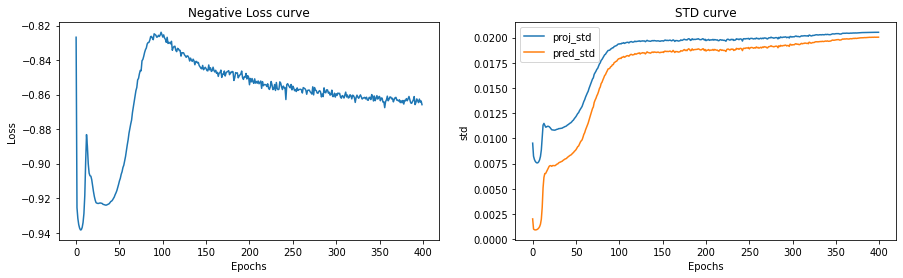

In [22]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Negative Loss curve")

plt.subplot(1,2,2)
plt.plot(history.history['proj_std'],label="proj_std")
plt.plot(history.history['pred_std'],label="pred_std")
plt.xlabel("Epochs")
plt.ylabel("std")
plt.title("STD curve") # range(0,1/sqrt(PROJECTION_DIM)) with 0 indicating a degenerate solution and vice versa
plt.legend()

In [23]:
backbone_path = f"backbone_{date}"
backbone.save(backbone_path)

2023-01-26 04:34:11.377522: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## Performing downstream task to validate the model

In [24]:
# backbone = tf.keras.models.load_model("/kaggle/input/self-supervised-approach-to-image-classification/backbone_2023 01 25/")

In [25]:
backbone.trainable = False
def linear_model(num_classes):
    inputs = tf.keras.Input(shape=[*C.SHAPE,3])
    x = backbone(inputs,training=False)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(num_classes,activation="softmax")(x)
    return tf.keras.Model(inputs=inputs,outputs=x)

model = linear_model(C.CLASSES)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 120, 120, 3)]     0         
_________________________________________________________________
backbone (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 120)               245880    
Total params: 23,833,592
Trainable params: 245,880
Non-trainable params: 23,587,712
_________________________________________________________________


In [26]:
def preprocess(image,label,train=True):
    image = tf.image.resize(image,C.SHAPE)
    if train:
#         image = tf.image.resize(image,C.SHAPE)
        image = random_crop_resize(image,C.HEIGHT,C.HEIGHT,area_range=C.SCALE)
        image = tf.image.random_flip_left_right(image)
        image = tf.clip_by_value(image,0.,255.)
        return image,label
    elif not train:
#         image = tf.image.resize(image,C.SHAPE)
        return image,label

In [27]:
train_ds = (
    train.map(partial(preprocess,train=True),num_parallel_calls=C.AUTO)
    .shuffle(C.BUFFER_SIZE)
    .batch(64)
    .prefetch(C.AUTO)
)

val_ds = (
    val.map(partial(preprocess,train=False),num_parallel_calls=C.AUTO)
    .batch(64)
    .prefetch(C.AUTO)
)

x_test = (
    test.map(partial(preprocess,train=False),num_parallel_calls=C.AUTO)
    .map(lambda x,y: x)
    .batch(64)
)

# y_test = (
#     test.map(partial(preprocess,train=False),num_parallel_calls=C.AUTO)
#     .map(lambda x,y: y)
#     .batch(64)
# )

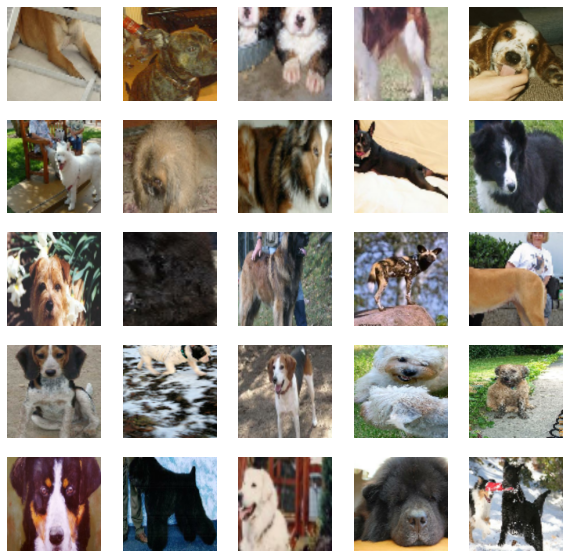

In [28]:
x,y = next(iter(train_ds))
visualize(x)

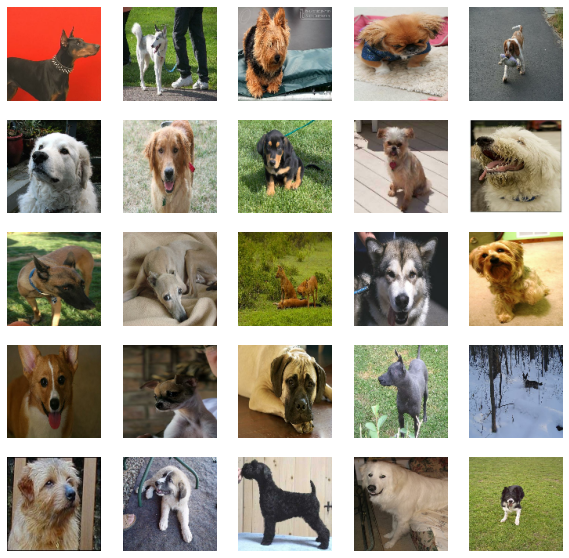

In [29]:
x,y = next(iter(val_ds))
visualize(x)

In [30]:
steps = 20 * tf.data.experimental.cardinality(train_ds) 
schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate = 30.0,
    decay_steps = steps
)


opt = tf.keras.optimizers.SGD(
    learning_rate = schedule,
    momentum = 0.9
)

model.compile(
    loss = "sparse_categorical_crossentropy",
    optimizer = opt,
    metrics = ['accuracy']
)


hist = model.fit(
    train_ds,
    steps_per_epoch = train_ds.cardinality().numpy(),
    validation_data = val_ds,
    validation_steps = val_ds.cardinality().numpy(),
    epochs = 20,
    verbose = 1
)

Epoch 1/20
 62/150 [===========>..................] - ETA: 7s - loss: 16339.2676 - accuracy: 0.2074

Cleanup called...


150/150 [==============================] - 21s 107ms/step - loss: 13792.8574 - accuracy: 0.2916 - val_loss: 12505.1152 - val_accuracy: 0.3917
Epoch 2/20
 62/150 [===========>..................] - ETA: 7s - loss: 10585.3213 - accuracy: 0.4095

Cleanup called...


150/150 [==============================] - 17s 103ms/step - loss: 10473.6738 - accuracy: 0.4214 - val_loss: 12478.9482 - val_accuracy: 0.4338
Epoch 3/20
 62/150 [===========>..................] - ETA: 8s - loss: 9627.1133 - accuracy: 0.4635

Cleanup called...


150/150 [==============================] - 17s 104ms/step - loss: 9624.4648 - accuracy: 0.4697 - val_loss: 13053.1504 - val_accuracy: 0.4288
Epoch 4/20
 62/150 [===========>..................] - ETA: 8s - loss: 9072.1748 - accuracy: 0.4970

Cleanup called...


150/150 [==============================] - 17s 106ms/step - loss: 9103.7100 - accuracy: 0.4976 - val_loss: 11767.0410 - val_accuracy: 0.4671
Epoch 5/20
 62/150 [===========>..................] - ETA: 7s - loss: 8317.7197 - accuracy: 0.5267

Cleanup called...


150/150 [==============================] - 16s 101ms/step - loss: 8263.0215 - accuracy: 0.5284 - val_loss: 11775.3691 - val_accuracy: 0.4817
Epoch 6/20
 62/150 [===========>..................] - ETA: 7s - loss: 7753.1831 - accuracy: 0.5421

Cleanup called...


150/150 [==============================] - 17s 102ms/step - loss: 7348.7441 - accuracy: 0.5514 - val_loss: 11371.6133 - val_accuracy: 0.4663
Epoch 7/20
 61/150 [===========>..................] - ETA: 12s - loss: 7182.3477 - accuracy: 0.5510

Cleanup called...


150/150 [==============================] - 20s 124ms/step - loss: 7163.8867 - accuracy: 0.5532 - val_loss: 10942.2803 - val_accuracy: 0.4817
Epoch 8/20
 62/150 [===========>..................] - ETA: 8s - loss: 6525.2598 - accuracy: 0.5696

Cleanup called...


150/150 [==============================] - 17s 103ms/step - loss: 6386.1294 - accuracy: 0.5744 - val_loss: 10373.5205 - val_accuracy: 0.5042
Epoch 9/20
 62/150 [===========>..................] - ETA: 8s - loss: 6205.0415 - accuracy: 0.5935

Cleanup called...


150/150 [==============================] - 17s 106ms/step - loss: 5811.8027 - accuracy: 0.5971 - val_loss: 9788.1992 - val_accuracy: 0.5029
Epoch 10/20
 62/150 [===========>..................] - ETA: 7s - loss: 5167.6841 - accuracy: 0.6217

Cleanup called...


150/150 [==============================] - 17s 103ms/step - loss: 5138.4258 - accuracy: 0.6224 - val_loss: 9059.7178 - val_accuracy: 0.5104
Epoch 11/20
 62/150 [===========>..................] - ETA: 10s - loss: 4638.3560 - accuracy: 0.6411

Cleanup called...


150/150 [==============================] - 19s 114ms/step - loss: 4680.1143 - accuracy: 0.6325 - val_loss: 8555.7520 - val_accuracy: 0.5208
Epoch 12/20
 62/150 [===========>..................] - ETA: 8s - loss: 4184.5269 - accuracy: 0.6454

Cleanup called...


150/150 [==============================] - 17s 107ms/step - loss: 4064.2346 - accuracy: 0.6589 - val_loss: 8275.0449 - val_accuracy: 0.5246
Epoch 13/20
 62/150 [===========>..................] - ETA: 7s - loss: 3570.8213 - accuracy: 0.6787

Cleanup called...


150/150 [==============================] - 16s 100ms/step - loss: 3545.2676 - accuracy: 0.6770 - val_loss: 7907.6665 - val_accuracy: 0.5263
Epoch 14/20
 62/150 [===========>..................] - ETA: 8s - loss: 3332.7725 - accuracy: 0.6920

Cleanup called...


150/150 [==============================] - 19s 117ms/step - loss: 3288.9446 - accuracy: 0.6906 - val_loss: 7625.9385 - val_accuracy: 0.5392
Epoch 15/20
 62/150 [===========>..................] - ETA: 7s - loss: 2890.7522 - accuracy: 0.7011

Cleanup called...


150/150 [==============================] - 19s 117ms/step - loss: 2935.6794 - accuracy: 0.7013 - val_loss: 7326.9883 - val_accuracy: 0.5496
Epoch 16/20
 62/150 [===========>..................] - ETA: 7s - loss: 2964.9246 - accuracy: 0.7009

Cleanup called...


150/150 [==============================] - 17s 101ms/step - loss: 2819.6741 - accuracy: 0.7122 - val_loss: 7137.3384 - val_accuracy: 0.5429
Epoch 17/20
 62/150 [===========>..................] - ETA: 7s - loss: 2696.9265 - accuracy: 0.7130

Cleanup called...


150/150 [==============================] - 17s 106ms/step - loss: 2608.4790 - accuracy: 0.7210 - val_loss: 6979.5342 - val_accuracy: 0.5462
Epoch 18/20
 62/150 [===========>..................] - ETA: 7s - loss: 2318.4333 - accuracy: 0.7379

Cleanup called...


150/150 [==============================] - 19s 118ms/step - loss: 2412.6169 - accuracy: 0.7295 - val_loss: 6887.7080 - val_accuracy: 0.5479
Epoch 19/20
 62/150 [===========>..................] - ETA: 7s - loss: 2199.3730 - accuracy: 0.7306

Cleanup called...


150/150 [==============================] - 20s 121ms/step - loss: 2257.8958 - accuracy: 0.7342 - val_loss: 6752.0894 - val_accuracy: 0.5492
Epoch 20/20
 62/150 [===========>..................] - ETA: 7s - loss: 2433.9753 - accuracy: 0.7223

Cleanup called...


150/150 [==============================] - 16s 102ms/step - loss: 2398.0186 - accuracy: 0.7261 - val_loss: 6745.6499 - val_accuracy: 0.5492


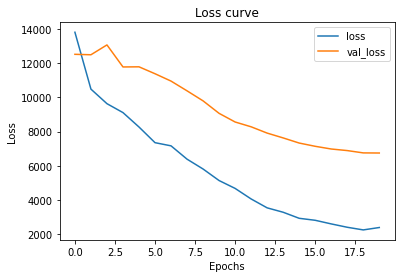

In [31]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss curve")
plt.legend(['loss','val_loss'])

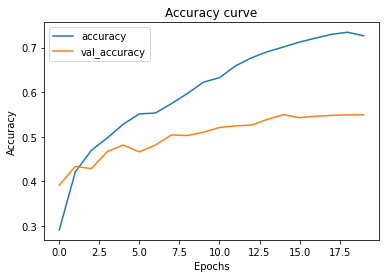

In [32]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy curve")
plt.legend(["accuracy","val_accuracy"])

In [33]:
y_pred = np.argmax(model.predict(x_test),axis=1)

In [34]:
y = []
for _,b in test.as_numpy_iterator():
    y.append(b)

In [35]:
print(accuracy_score(y,y_pred))

0.5621212121212121
